In [1]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-05-25 19:44:44--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.204.138, 74.125.204.113, 74.125.204.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.204.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-05-25 19:44:45--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.8.132, 2404:6800:4008:c15::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.8.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  38.7MB/s    in 0.5s    

2025-05-25 19:44:51

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import math

In [4]:
pd.set_option("display.max_rows", None)

###檢查有輪調的法官

#### 法官data

In [ ]:
years = range(2016,2023)
for year in years:
  print(year)

2016
2017
2018
2019
2020
2021
2022


In [ ]:
original_df = pd.DataFrame()

In [ ]:
for year in years:
  judge_df = pd.read_csv(f"/content/gdrive/MyDrive/NCHU/論文/酒駕資料/{year}_判決對應法官_清洗字符後.csv", encoding="utf-8", index_col=0)
  original_df = pd.concat([original_df, judge_df])

In [ ]:
original_df.head()

,案號,法官
1,"CHDM,104,交簡,2448,20160104,1",黃玉齡
2,"CHDM,104,交簡,2461,20160105,1",黃玉齡
3,"CHDM,104,交簡,2479,20160115,1",黃玉齡
4,"CHDM,104,交簡,2495,20160125,1",張琇涵
5,"CHDM,104,交簡,2659,20160111,1",陳佳妤


In [ ]:
judge_list = original_df["法官"].unique()

In [ ]:
judge_list

array(['黃玉齡', '張琇涵', '陳佳妤', ..., '林秉賢', '陳怡君法官。', '邱于真'], dtype=object)

#### 找

In [ ]:
from collections import defaultdict

# 使用 defaultdict 來收集法官對應的法院
judge_court_map = defaultdict(set)

# 遍歷 DataFrame，每一行都提取法院名稱並存入對應法官
for _, row in original_df.iterrows():
    court_name = row["案號"].split(",")[0]  # 提取案號的第一部分作為法院名稱
    judge_court_map[row["法官"]].add(court_name)

# 轉換為 DataFrame
result_df = pd.DataFrame({
    "法官": judge_court_map.keys(),
    "任職法院": [", ".join(courts) for courts in judge_court_map.values()],
    "法院數量": [len(courts) for courts in judge_court_map.values()]
})


In [ ]:
# 篩選出 任職法院數 > 3 的法官
multiple_courts_df = result_df[result_df["法院數量"] > 3]

In [ ]:
# 顯示結果
#print("共有"+str(len(multiple_courts_df))+"位法官有輪調")
print(multiple_courts_df)

      法官                    任職法院  法院數量
58   蔡鎮宇  TPDM, ULDM, HUEM, PKEM     4
60   陳育良  ULDM, NTDM, HUEM, PKEM     4
172  王紹銘  ULDM, TLEM, HUEM, PKEM     4
518  黃麗竹  ULDM, TCDM, HUEM, PKEM     4


###子實驗一

In [5]:
judgemnt_df = pd.read_csv("/content/gdrive/MyDrive/NCHU/論文/酒駕資料/2016to22_判決結構化資料_清洗整理後_有序資料編碼修正後v2_含法官.csv", encoding="utf-8", index_col=0)

####全台灣資料

In [6]:
tw_df = judgemnt_df.copy()

In [7]:
bins = [-float('inf'), 0.24, 0.49, 0.74, 0.99, 1.49, 1.99, 3.49, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]  # 數值對應類別

# 假設 df 中有一個欄位名稱為 '呼氣酒精濃度'
tw_df['酒精濃度類別'] = pd.cut(tw_df['呼氣酒精濃度'], bins=bins, labels=labels, right=True).astype(int)

# 解析案號中的年份
#tw_df["年份"] = tw_df["案號"].apply(lambda x: int(x.split(",")[1]))

# 篩選 105 年以後的案件
#tw_df = tw_df[tw_df["年份"] >= 105]

# 移除無關欄位
tw_df = tw_df.drop(columns=["案號", "年份", "易科罰金", "併科罰金", "呼氣酒精濃度","法官","法院"])
# 移除有 NaN 的資料列
tw_df = tw_df.dropna()

In [8]:
tw_df.head()

,刑期,是否累犯,是否坦承犯行,有無出現交通事故,有無乘客,是否為職業駕駛,交通工具,家庭經濟,教育程度,除酒駕以外的交通違規,酒精濃度類別
0,3,0,1,1,0,0,4,3,3,0,2
1,6,1,1,0,0,0,2,1,2,0,5
2,4,0,1,0,0,0,2,0,2,2,3
3,2,0,1,1,0,0,2,0,4,0,4
4,4,1,1,0,2,0,2,0,3,0,2


In [9]:
len(tw_df)

31949

#####分類

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (
    classification_report, f1_score,
    mean_absolute_error, mean_squared_error, r2_score
)

# 📌 分類標籤（重標籤）設定
def label_sentence(months):
    if months <= 3:
        return 0  # 輕刑
    elif months <= 5:
        return 1  # 中刑
    else:
        return 2  # 重刑

# 🧾 載入資料（請將這行換成你自己的檔案）
# tw_df = pd.read_csv("your_file.csv")  # <-- 改成你的資料來源

# =========================
# 📦 資料準備
# =========================
tw_df['sentence_level'] = tw_df['刑期'].apply(label_sentence)
X = tw_df.drop(columns=['刑期', 'sentence_level'])
y_reg = tw_df['刑期']
y_cls = tw_df['sentence_level']
y_raw = tw_df['刑期']

# LabelEncoder for raw_cls
label_encoder = LabelEncoder()
y_raw_encoded = label_encoder.fit_transform(y_raw)

# 分割所有資料（統一 stratify by 重標籤 y_cls）
X_train, X_test, y_cls_train, y_cls_test, y_reg_train, y_reg_test, y_raw_train, y_raw_test, y_raw_encoded_train, y_raw_encoded_test = train_test_split(
    X, y_cls, y_reg, y_raw, y_raw_encoded,
    test_size=0.2, random_state=42, stratify=y_cls
)



In [ ]:
# =========================
# ✅ 分類模型清單
# =========================
models_cls = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# =========================
# ✅ 分類任務：不重標籤（raw_cls）
# =========================
print("📘 [不重標籤分類模型（raw_cls）]")
for name, model in models_cls.items():
    model.fit(X_train, y_raw_encoded_train)
    preds = model.predict(X_test)

    labels = np.unique(y_raw_encoded_train)
    class_names = [str(c) for c in label_encoder.inverse_transform(labels)]

    report = classification_report(y_raw_encoded_test, preds, target_names=class_names, labels=labels)
    macro_f1 = f1_score(y_raw_encoded_test, preds, average='macro')

    print(f"\n▶ {name}")
    print(report)
    print(f"Macro F1-score: {macro_f1:.4f}")

# =========================
# ✅ 分類任務：重標籤（cls）
# =========================
print("\n📘 [重標籤分類模型（cls）]")
for name, model in models_cls.items():
    model.fit(X_train, y_cls_train)
    preds = model.predict(X_test)

    labels = [0, 1, 2]
    target_names = ["輕刑", "中刑", "重刑"]

    report = classification_report(y_cls_test, preds, target_names=target_names, labels=labels)
    macro_f1 = f1_score(y_cls_test, preds, average='macro')

    print(f"\n▶ {name}")
    print(report)
    print(f"Macro F1-score: {macro_f1:.4f}")



In [11]:
# =========================
# ✅ 回歸模型清單
# =========================
models_reg = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression d=2': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Polynomial Regression d=3': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    'Regression Tree': DecisionTreeRegressor(),
    'XGBoost Regressor': XGBRegressor(),
    'XGBoost Regressor (tuned)': XGBRegressor(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42
    ),
    'LightGBM': LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42),
    'Stacking Regressor': StackingRegressor(
        estimators=[
            ('lr', Ridge()),
            ('tree', DecisionTreeRegressor(max_depth=4)),
            ('xgb', XGBRegressor(
                n_estimators=300, max_depth=4, learning_rate=0.05,
                subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42
            ))
        ],
        final_estimator=Ridge()
    )
}

# =========================
# ✅ 回歸任務：reg
# =========================
print("\n📗 [回歸模型（reg）]")
for name, model in models_reg.items():
    model.fit(X_train, y_reg_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_reg_test, preds)
    mse = mean_squared_error(y_reg_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_reg_test, preds)

    print(f"\n▶ {name}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 : {r2:.4f}")


📗 [回歸模型（reg）]

▶ Linear Regression
MAE: 0.7907
MSE: 0.9519
RMSE: 0.9756
R2 : 0.4282

▶ Polynomial Regression d=2
MAE: 0.7779
MSE: 0.9287
RMSE: 0.9637
R2 : 0.4421

▶ Polynomial Regression d=3
MAE: 0.7747
MSE: 0.9247
RMSE: 0.9616
R2 : 0.4445

▶ Regression Tree
MAE: 0.7977
MSE: 1.0440
RMSE: 1.0218
R2 : 0.3728

▶ XGBoost Regressor
MAE: 0.7747
MSE: 0.9340
RMSE: 0.9664
R2 : 0.4389

▶ XGBoost Regressor (tuned)
MAE: 0.7723
MSE: 0.9169
RMSE: 0.9575
R2 : 0.4492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 25559, number of used features: 10
[LightGBM] [Info] Start training from score 3.357995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective='multi:softprob',  # 多分類機率預測
    num_class=3,                 # 若你的分類任務是輕刑 / 中刑 / 重刑
    n_estimators=300,           # 樹的數量（可視資料大小調整）
    max_depth=4,                # 控制樹的深度，防止過擬合
    learning_rate=0.05,         # 學習速率（小一點通常效果更穩）
    subsample=0.8,              # 每棵樹用多少樣本，防過擬合
    colsample_bytree=0.8,       # 每棵樹用多少特徵
    reg_alpha=0.1,              # L1 正則化（控制模型複雜度）
    reg_lambda=1.0,             # L2 正則化
    gamma=0.1,                  # 最小損失減少，控制分裂節點
    min_child_weight=5,         # 每個葉節點最小樣本權重和
    use_label_encoder=False,    # 關掉 label encoder（較新版本建議）
    eval_metric='mlogloss',     # 多分類損失函數
    random_state=42             # 確保可重現
)

xgb_clf.fit(X_train, y_cls_train)
preds = xgb_clf.predict(X_test)
print(f"\n{name}\n", classification_report(y_cls_test, preds, target_names=["輕刑", "中刑", "重刑"]))


##### 回歸

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


models_reg = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    'Regression Tree': DecisionTreeRegressor(),
    'XGBoost Regressor': XGBRegressor()
}

for name, model in models_reg.items():
    model.fit(X_train, y_reg_train)
    pred = model.predict(X_test)
    print(f"\n{name}")
    print("MAE:", mean_absolute_error(y_reg_test, pred))
    print("MSE:", mean_squared_error(y_reg_test, pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_reg_test, pred)))
    print("R2 :", r2_score(y_reg_test, pred))



Linear Regression
MAE: 0.7906556709664392
MSE: 0.9518658743204603
RMSE: 0.9756361382813064
R2 : 0.4281907770342688

Polynomial Regression
MAE: 0.77466755284449
MSE: 0.9246679710617326
RMSE: 0.9615965739652635
R2 : 0.4445292259147613

Regression Tree
MAE: 0.7993970042500241
MSE: 1.0496719268549974
RMSE: 1.0245349807864041
R2 : 0.36943627767684073

XGBoost Regressor
MAE: 0.7747177481651306
MSE: 0.9339928030967712
RMSE: 0.9664330308390598
R2 : 0.4389275908470154


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 假設你有 X (DataFrame) 與 y
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_train)  # X 是你的原始特徵（例如 data[['是否累犯', '酒精濃度', ...]]）

# 對應的特徵名稱
feature_names = poly.get_feature_names_out(input_features=X_train.columns)

# 訓練模型
model = LinearRegression()
model.fit(X_poly, y_reg_train)

# 印出每個係數與對應變數（就是解釋力來源）
for name, coef in zip(feature_names, model.coef_):
    print(f"{name}: {coef:.4f}")

In [ ]:
# 整理係數與特徵名稱，依絕對值排序
coef_df = pd.DataFrame({
    "特徵名稱": feature_names,
    "係數": model.coef_
})
coef_df["|係數|"] = coef_df["係數"].abs()
coef_df_sorted = coef_df.sort_values(by="|係數|", ascending=False).drop(columns="|係數|")

# 顯示前幾個重要特徵
print(coef_df_sorted.head(20))

In [ ]:
from xgboost import XGBRegressor

xgb_opt = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

xgb_opt.fit(X_train, y_reg_train)
y_pred = xgb_opt.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_reg_test, y_pred)
mse = mean_squared_error(y_reg_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 : {r2:.4f}")


In [ ]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
lgbm.fit(X_train, y_reg_train)
y_pred = lgbm.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_reg_test, y_pred)
mse = mean_squared_error(y_reg_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 : {r2:.4f}")


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

stack = StackingRegressor(
    estimators=[
        ('lr', Ridge()),
        ('tree', DecisionTreeRegressor(max_depth=4)),
        ('xgb', xgb_opt)
    ],
    final_estimator=Ridge()
)
stack.fit(X_train, y_reg_train)

y_pred = stack.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_reg_test, y_pred)
mse = mean_squared_error(y_reg_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 : {r2:.4f}")


#### 法院(分類回歸寫成func了)

In [13]:
judgemnt_df.head()

,案號,刑期,呼氣酒精濃度,是否累犯,是否坦承犯行,有無出現交通事故,有無乘客,是否為職業駕駛,交通工具,家庭經濟,教育程度,除酒駕以外的交通違規,易科罰金,併科罰金,年份,法官,法院
0,"CHDM,105,交簡,156,20160130,1",3,0.360,0,1,1,0,0,4,3,3,0,1,0.0,105,林于捷,CHDM
1,"CHDM,105,交簡,6,20160114,1",6,1.220,1,1,0,0,0,2,1,2,0,1,0.0,105,張佳燉,CHDM
2,"CHDM,105,審交簡,4,20160126,1",4,0.530,0,1,0,0,0,2,0,2,2,1,20.0,105,呂美玲,CHDM
3,"CPEM,105,竹北交簡,2,20160127,1",2,0.865,0,1,1,0,0,2,0,4,0,1,0.0,105,傅曉瑄,CPEM
4,"CPEM,105,竹北交簡,30,20160127,1",4,0.270,1,1,0,2,0,2,0,3,0,1,0.0,105,傅曉瑄,CPEM


In [29]:
court_df = judgemnt_df.copy()

In [30]:
bins = [-float('inf'), 0.24, 0.49, 0.74, 0.99, 1.49, 1.99, 3.49, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]  # 數值對應類別

# 假設 df 中有一個欄位名稱為 '呼氣酒精濃度'
court_df['酒精濃度類別'] = pd.cut(court_df['呼氣酒精濃度'], bins=bins, labels=labels, right=True).astype(int)

# 解析案號中的年份
#court_df["年份"] = court_df["案號"].apply(lambda x: int(x.split(",")[1]))

# 篩選 105 年以後的案件
#court_df = court_df[court_df["年份"] >= 105]

# 移除無關欄位
court_df = court_df.drop(columns=["案號", "年份", "易科罰金", "併科罰金", "呼氣酒精濃度", "法官"])

# 移除有 NaN 的資料列
court_df = court_df.dropna()

In [31]:
court_df.head()

,刑期,是否累犯,是否坦承犯行,有無出現交通事故,有無乘客,是否為職業駕駛,交通工具,家庭經濟,教育程度,除酒駕以外的交通違規,法院,酒精濃度類別
0,3,0,1,1,0,0,4,3,3,0,CHDM,2
1,6,1,1,0,0,0,2,1,2,0,CHDM,5
2,4,0,1,0,0,0,2,0,2,2,CHDM,3
3,2,0,1,1,0,0,2,0,4,0,CPEM,4
4,4,1,1,0,2,0,2,0,3,0,CPEM,2


In [32]:
grouped = court_df.groupby('法院')

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score, f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

In [34]:
from sklearn.tree import DecisionTreeClassifier

def run_classification_models_raw(X_train, X_test, y_train, y_test, court_name):
    header = f"\n📘 [分類模型-不重標籤] 法院：{court_name}\n" + "=" * 40
    print(header)
    write_to_log('court_classification_raw_results.txt', f"訓練資料筆數：{X_train.shape[0]}")
    write_to_log('court_classification_raw_results.txt', f"測試資料筆數：{X_test.shape[0]}")
    write_to_log('court_classification_raw_results.txt', header)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM': SVC(probability=True),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 直接根據 y_test 裡的標籤生成對應名稱
        present_labels = unique_labels(y_test, y_pred)
        present_label_names = [str(lbl) for lbl in present_labels]  # 不轉換標籤，只保留數值

        # 文字報告 + 自計 Macro F1-score
        report = classification_report(y_test, y_pred, target_names=present_label_names, labels=present_labels)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        report += f"\nMacro F1-score: {macro_f1:.4f}"

        # 印出與寫入
        section = f"\n▶ {name}\n{report}"
        print(section)
        write_to_log('court_classification_raw_results.txt', section)


In [35]:
from sklearn.utils.multiclass import unique_labels

def run_classification_models(X_train, X_test, y_train, y_test, court_name):
    header = f"\n📘 [分類模型] 法院：{court_name}\n" + "=" * 40
    print(header)
    #寫入資料筆數
    write_to_log('court_classification_results.txt', f"訓練資料筆數：{X_train.shape[0]}")
    write_to_log('court_classification_results.txt', f"測試資料筆數：{X_test.shape[0]}")
    write_to_log('court_classification_results.txt', header)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM': SVC(probability=True),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    }

    label_name_map = {0: "輕刑", 1: "中刑", 2: "重刑"}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # 根據實際出現的類別自動取得對應標籤名稱
        present_labels = unique_labels(y_test, y_pred)
        present_label_names = [label_name_map[i] for i in present_labels]

        # 文字報告 + 自計 Macro F1-score
        report = classification_report(y_test, y_pred, target_names=present_label_names, labels=present_labels)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        report += f"\nMacro F1-score: {macro_f1:.4f}"

        # 印出與寫入
        section = f"\n▶ {name}\n{report}"
        print(section)
        write_to_log('court_classification_results.txt', section)


In [36]:
def run_regression_models(X_train, X_test, y_train, y_test, court_name):
    header = f"\n📗 [回歸模型] 法院：{court_name}\n" + "=" * 40
    print(header)
    #寫入資料筆數
    write_to_log('court_regression_results.txt', f"訓練資料筆數：{X_train.shape[0]}")
    write_to_log('court_regression_results.txt', f"測試資料筆數：{X_test.shape[0]}")
    write_to_log('court_regression_results.txt', header)

    models = {
        'Linear Regression': LinearRegression(),
        'Polynomial Regression d=2': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
        'Polynomial Regression d=3': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
        'XGBoost Regressor': XGBRegressor(),
        'XGBoost Regressor(included hyper parameters)': XGBRegressor(
            n_estimators=300, max_depth=4, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42
        ),
        'LightGBM': LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42),
        'Stacking Regressor': StackingRegressor(
            estimators=[
                ('lr', Ridge()),
                ('tree', DecisionTreeRegressor(max_depth=4)),
                ('xgb', XGBRegressor(
                    n_estimators=300, max_depth=4, learning_rate=0.05,
                    subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42
                ))
            ],
            final_estimator=Ridge()
        )
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        result = f"\n▶ {name}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2 : {r2:.4f}"
        print(result)
        write_to_log('court_regression_results.txt', result)


In [37]:
def write_to_log(filename, content):
    with open(filename, 'a', encoding='utf-8') as f:
        f.write(content + '\n')

In [38]:
from sklearn.preprocessing import LabelEncoder

# 初始化三份結果檔
open('court_classification_raw_results.txt', 'w').close()
open('court_classification_results.txt', 'w').close()
open('court_regression_results.txt', 'w').close()

for court, group_df in grouped:
    print(f"\n================ 法院：{court} ================\n")
    print(f"資料筆數：{group_df.shape[0]}")

    # 篩掉樣本過少的法院
    if group_df.shape[0] < 10:
        msg = f"⚠️ 法院 {court} 樣本數僅 {group_df.shape[0]}，不足以切分訓練測試集，已跳過。"
        print(msg)
        write_to_log('court_classification_raw_results.txt', msg)
        write_to_log('court_classification_results.txt', msg)
        write_to_log('court_regression_results.txt', msg)
        continue

    # 特徵處理
    features = group_df.drop(columns=['刑期', '法院']).copy()

    # ================================
    # y1: 不重標籤（原始刑期作為類別）
    label_encoder = LabelEncoder()
    y_cls_raw_all = label_encoder.fit_transform(group_df['刑期'])

    # y2: 重標籤（3 類）
    y_cls_all = group_df['刑期'].apply(label_sentence)

    # y3: 回歸
    y_reg_all = group_df['刑期']

    # ================================
    # 資料切分（加入 stratify）
    try:
        X_train, X_test, y_cls_raw_train, y_cls_raw_test = train_test_split(
            features, y_cls_raw_all, test_size=0.2, random_state=42, stratify=y_cls_raw_all)

        _, _, y_cls_train, y_cls_test = train_test_split(
            features, y_cls_all, test_size=0.2, random_state=42, stratify=y_cls_all)

        _, _, y_reg_train, y_reg_test = train_test_split(
            features, y_reg_all, test_size=0.2, random_state=42)

    except ValueError as e:
        msg = f"⚠️ 法院 {court} 無法 stratify 分層切分：{str(e)}，已跳過。"
        print(msg)
        write_to_log('court_classification_raw_results.txt', msg)
        write_to_log('court_classification_results.txt', msg)
        write_to_log('court_regression_results.txt', msg)
        continue

    # ================================
    # 執行三種模型

    # 1. 不重標籤分類模型
    #run_classification_models_raw(X_train, X_test, y_cls_raw_train, y_cls_raw_test, court)

    # 2. 重標籤分類模型
    #run_classification_models(X_train, X_test, y_cls_train, y_cls_test, court)

    # 3. 回歸模型
    run_regression_models(X_train, X_test, y_reg_train, y_reg_test, court)


串流輸出內容已截斷至最後 5000 行。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

#####法院原標籤分類

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import numpy as np

# 初始化 log 檔案
open('court_classification_raw_results.txt', 'w').close()

# 模型清單（與法院實驗一致）
models_cls = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# 實驗主程式
for court, group_df in grouped:
    print(f"\n================ 法院：{court} ================\n")

    if group_df.shape[0] < 10:
        msg = f"⚠️ 法院 {court} 樣本數僅 {group_df.shape[0]}，不足以切分訓練測試集，已跳過。"
        print(msg)
        write_to_log('court_classification_raw_results.txt', msg)
        continue

    # 特徵與原始刑期
    features = group_df.drop(columns=['刑期', '法院'])
    y_raw = group_df['刑期']

    # LabelEncoder：先 fit 全部 y_raw，保證完整類別映射
    label_encoder = LabelEncoder()
    y_raw_encoded = label_encoder.fit_transform(y_raw)

    # 一次切分 X 和 y_encoded
    X_train, X_test, y_train, y_test = train_test_split(
        features, y_raw_encoded, test_size=0.2, random_state=42)

    # === 開始跑模型 ===
    header = f"\n📘 [分類模型-不重標籤] 法院：{court}\n" + "=" * 40
    write_to_log('court_classification_raw_results.txt', f"訓練資料筆數：{X_train.shape[0]}")
    write_to_log('court_classification_raw_results.txt', f"測試資料筆數：{X_test.shape[0]}")
    write_to_log('court_classification_raw_results.txt', header)

    for name, model in models_cls.items():
        try:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            labels = np.unique(y_train)
            class_names = [str(x) for x in label_encoder.inverse_transform(labels)]

            report = classification_report(y_test, preds, target_names=class_names, labels=labels)
            macro_f1 = f1_score(y_test, preds, average='macro')

            section = f"\n▶ {name}\n{report}\nMacro F1-score: {macro_f1:.4f}"
            print(section)
            write_to_log('court_classification_raw_results.txt', section)

        except ValueError as e:
            section = f"\n▶ {name} ❌ 發生錯誤：{str(e)}"
            print(section)
            write_to_log('court_classification_raw_results.txt', section)



================ 法院：CHDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.56      0.72      0.63        43
         3.0       0.48      0.66      0.56        76
         4.0       0.50      0.20      0.29        40
         5.0       0.50      0.13      0.21        23
         6.0       0.56      0.60      0.58        25

   micro avg       0.51      0.52      0.52       207
   macro avg       0.52      0.46      0.45       207
weighted avg       0.51      0.52      0.48       207

Macro F1-score: 0.3763

▶ SVM
              precision    recall  f1-score   support

         2.0       0.59      0.67      0.63        43
         3.0       0.42      0.78      0.55        76
         4.0       0.00      0.00      0.00        40
         5.0       0.14      0.04      0.07        23
         6.0       0.50      0.16      0.24        25

   micro avg       0.45      0.45      0.45       207
   macro avg       0.33      0.33 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.55      0.74      0.63        43
         3.0       0.50      0.54      0.52        76
         4.0       0.31      0.25      0.28        40
         5.0       0.12      0.09      0.10        23
         6.0       0.35      0.28      0.31        25

   micro avg       0.44      0.44      0.44       207
   macro avg       0.37      0.38      0.37       207
weighted avg       0.41      0.44      0.42       207

Macro F1-score: 0.3074

================ 法院：CPEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.62      0.36      0.45        28
         3.0       0.26      0.59      0.36        22
         4.0       0.43      0.31      0.36        32
         5.0       0.29      0.17      0.21        12
         6.0       0.00      0.00      0.00         5

    accuracy                           0.35        99
   macro avg       0.32      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ SVM
              precision    recall  f1-score   support

         2.0       0.85      0.39      0.54        28
         3.0       0.34      0.91      0.50        22
         4.0       0.57      0.41      0.47        32
         5.0       0.40      0.17      0.24        12
         6.0       0.00      0.00      0.00         5

    accuracy                           0.46        99
   macro avg       0.43      0.37      0.35        99
weighted avg       0.55      0.46      0.44        99

Macro F1-score: 0.3489

▶ Decision Tree
              precision    recall  f1-score   support

         2.0       0.65      0.54      0.59        28
         3.0       0.35      0.77      0.49        22
         4.0       0.56      0.31      0.40        32
         5.0       0.33      0.17      0.22        12
         6.0       0.00      0.00      0.00         5

    accuracy                           0.44        99
   macro avg       0.38      0.36      0.34        99
weighted avg       0.48      0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.64      0.50      0.56        28
         3.0       0.37      0.68      0.48        22
         4.0       0.52      0.38      0.44        32
         5.0       0.38      0.25      0.30        12
         6.0       0.20      0.20      0.20         5

    accuracy                           0.45        99
   macro avg       0.42      0.40      0.39        99
weighted avg       0.49      0.45      0.45        99

Macro F1-score: 0.3945

================ 法院：CTDM ================



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Logistic Regression
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.62      0.97      0.75       236
         3.0       0.33      0.12      0.17       137
         4.0       0.27      0.19      0.22        84
         5.0       0.29      0.13      0.18        63
         6.0       0.30      0.41      0.35        46

   micro avg       0.51      0.51      0.51       566
   macro avg       0.30      0.30      0.28       566
weighted avg       0.44      0.51      0.44       566

Macro F1-score: 0.2788


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ SVM
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.62      0.98      0.76       236
         3.0       0.32      0.11      0.16       137
         4.0       0.25      0.40      0.31        84
         5.0       0.00      0.00      0.00        63
         6.0       0.38      0.11      0.17        46

   micro avg       0.50      0.50      0.50       566
   macro avg       0.26      0.27      0.23       566
weighted avg       0.40      0.50      0.42       566

Macro F1-score: 0.2338

▶ Decision Tree
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.67      0.81      0.73       236
         3.0       0.33      0.31      0.32       137
         4.0       0.24      0.19      0.21        84
         5.0       0.27      0.19      0.22        63
         6.0       0.18      0.15      0.17        46

   micro avg       0.47      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Random Forest
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.66      0.79      0.72       236
         3.0       0.33      0.31      0.32       137
         4.0       0.22      0.17      0.19        84
         5.0       0.30      0.17      0.22        63
         6.0       0.20      0.24      0.22        46

   micro avg       0.47      0.47      0.47       566
   macro avg       0.29      0.28      0.28       566
weighted avg       0.44      0.47      0.45       566

Macro F1-score: 0.2789


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ XGBoost
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.67      0.91      0.77       236
         3.0       0.38      0.27      0.31       137
         4.0       0.19      0.14      0.16        84
         5.0       0.29      0.16      0.20        63
         6.0       0.27      0.30      0.29        46

   micro avg       0.51      0.51      0.51       566
   macro avg       0.30      0.30      0.29       566
weighted avg       0.45      0.51      0.47       566

Macro F1-score: 0.2908

================ 法院：CYDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.42      0.52      0.47        21
         3.0       0.55      0.53      0.54        58
         4.0       0.23      0.38      0.29        29
         5.0       0.50      0.22      0.31        27
         6.0       0.55      0.42      0.48        26

    accuracy                  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ SVM
              precision    recall  f1-score   support

         2.0       0.56      0.67      0.61        21
         3.0       0.59      0.60      0.60        58
         4.0       0.20      0.48      0.28        29
         5.0       0.00      0.00      0.00        27
         6.0       0.43      0.12      0.18        26

    accuracy                           0.41       161
   macro avg       0.36      0.37      0.33       161
weighted avg       0.39      0.41      0.38       161

Macro F1-score: 0.3343

▶ Decision Tree
              precision    recall  f1-score   support

         2.0       0.42      0.62      0.50        21
         3.0       0.56      0.41      0.48        58
         4.0       0.20      0.28      0.23        29
         5.0       0.41      0.44      0.43        27
         6.0       0.39      0.27      0.32        26

    accuracy                           0.40       161
   macro avg       0.40      0.40      0.39       161
weighted avg       0.42      0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ SVM
              precision    recall  f1-score   support

         2.0       0.38      0.83      0.53         6
         3.0       0.00      0.00      0.00         5
         4.0       0.25      0.22      0.24         9
         5.0       0.67      0.89      0.77        37
         6.0       0.00      0.00      0.00        13

    accuracy                           0.57        70
   macro avg       0.26      0.39      0.31        70
weighted avg       0.42      0.57      0.48        70

Macro F1-score: 0.3058

▶ Decision Tree
              precision    recall  f1-score   support

         2.0       0.67      1.00      0.80         6
         3.0       0.00      0.00      0.00         5
         4.0       0.17      0.11      0.13         9
         5.0       0.66      0.84      0.74        37
         6.0       0.20      0.08      0.11        13

    accuracy                           0.56        70
   macro avg       0.34      0.41      0.36        70
weighted avg       0.46      0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.67      1.00      0.80         6
         3.0       0.50      0.20      0.29         5
         4.0       0.33      0.22      0.27         9
         5.0       0.67      0.84      0.75        37
         6.0       0.29      0.15      0.20        13

    accuracy                           0.60        70
   macro avg       0.49      0.48      0.46        70
weighted avg       0.54      0.60      0.56        70

Macro F1-score: 0.4599

================ 法院：HLDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.68      0.88      0.77        34
         3.0       0.59      0.57      0.58        30
         4.0       0.50      0.14      0.22         7
         5.0       1.00      0.20      0.33         5
         6.0       0.00      0.00      0.00         3

    accuracy                           0.62        79
   macro avg       0.55      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ Random Forest
              precision    recall  f1-score   support

         2.0       0.68      0.82      0.75        34
         3.0       0.52      0.37      0.43        30
         4.0       0.12      0.14      0.13         7
         5.0       0.40      0.40      0.40         5
         6.0       0.50      0.67      0.57         3

    accuracy                           0.56        79
   macro avg       0.45      0.48      0.46        79
weighted avg       0.55      0.56      0.54        79

Macro F1-score: 0.4566

▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.67      0.76      0.71        34
         3.0       0.59      0.43      0.50        30
         4.0       0.25      0.29      0.27         7
         5.0       0.60      0.60      0.60         5
         6.0       0.40      0.67      0.50         3

    accuracy                           0.58        79
   macro avg       0.50      0.55      0.52        79
weighted avg       0.59   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ SVM
              precision    recall  f1-score   support

         2.0       0.29      0.14      0.19        14
         3.0       0.36      0.71      0.48        14
         4.0       0.00      0.00      0.00         7
         5.0       0.00      0.00      0.00         3
         6.0       0.50      0.40      0.44         5

    accuracy                           0.33        43
   macro avg       0.23      0.25      0.22        43
weighted avg       0.27      0.33      0.27        43

Macro F1-score: 0.2222

▶ Decision Tree
              precision    recall  f1-score   support

         2.0       0.70      0.50      0.58        14
         3.0       0.38      0.57      0.46        14
         4.0       0.38      0.43      0.40         7
         5.0       0.00      0.00      0.00         3
         6.0       0.33      0.20      0.25         5

    accuracy                           0.44        43
   macro avg       0.36      0.34      0.34        43
weighted avg       0.45      0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ SVM
              precision    recall  f1-score   support

         2.0       0.62      0.89      0.73        38
         3.0       0.45      0.52      0.48        27
         4.0       0.50      0.09      0.15        23
         5.0       0.00      0.00      0.00         7
         6.0       0.52      0.69      0.59        16

    accuracy                           0.55       111
   macro avg       0.42      0.44      0.39       111
weighted avg       0.50      0.55      0.48       111

Macro F1-score: 0.3913

▶ Decision Tree
              precision    recall  f1-score   support

         2.0       0.64      0.76      0.70        38
         3.0       0.39      0.33      0.36        27
         4.0       0.37      0.30      0.33        23
         5.0       0.00      0.00      0.00         7
         6.0       0.40      0.50      0.44        16

    accuracy                           0.48       111
   macro avg       0.36      0.38      0.37       111
weighted avg       0.45      0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.59      0.88      0.71        66
         3.0       0.47      0.28      0.35        61
         4.0       0.26      0.41      0.32        27
         5.0       0.00      0.00      0.00        14
         6.0       1.00      0.08      0.14        13

    accuracy                           0.48       181
   macro avg       0.47      0.33      0.30       181
weighted avg       0.49      0.48      0.43       181

Macro F1-score: 0.3039

▶ SVM
              precision    recall  f1-score   support

         2.0       0.61      0.89      0.72        66
         3.0       0.50      0.36      0.42        61
         4.0       0.28      0.41      0.33        27
         5.0       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        13

    accuracy                           0.51       181
   macro avg       0.28      0.33      0.29       181
weighted avg       0.43 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ Random Forest
              precision    recall  f1-score   support

         2.0       0.68      0.76      0.71        66
         3.0       0.54      0.51      0.53        61
         4.0       0.30      0.30      0.30        27
         5.0       0.24      0.29      0.26        14
         6.0       0.17      0.08      0.11        13

    accuracy                           0.52       181
   macro avg       0.38      0.38      0.38       181
weighted avg       0.50      0.52      0.51       181

Macro F1-score: 0.3799

▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.66      0.74      0.70        66
         3.0       0.48      0.43      0.45        61
         4.0       0.24      0.30      0.27        27
         5.0       0.29      0.29      0.29        14
         6.0       0.17      0.08      0.11        13

    accuracy                           0.49       181
   macro avg       0.37      0.37      0.36       181
weighted avg       0.47   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w


▶ Logistic Regression
              precision    recall  f1-score   support

         3.0       0.50      0.40      0.44         5
         4.0       0.29      0.67      0.40         3
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         4

   micro avg       0.29      0.33      0.31        12
   macro avg       0.20      0.27      0.21        12
weighted avg       0.28      0.33      0.29        12

Macro F1-score: 0.1689

▶ SVM
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         5
         4.0       0.21      1.00      0.35         3
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         4

   micro avg       0.21      0.25      0.23        12
   macro avg       0.05      0.25      0.09        12
weighted avg       0.05      0.25      0.09        12

Macro F1-score: 0.0882

▶ Decision Tree
              precision    recall  f1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Logistic Regression
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.48      0.78      0.59       473
         3.0       0.33      0.30      0.32       493
         4.0       0.40      0.18      0.24       310
         5.0       0.23      0.19      0.21       202
         6.0       0.37      0.26      0.31       146
         7.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         0

    accuracy                           0.40      1626
   macro avg       0.23      0.21      0.21      1626
weighted avg       0.38      0.40      0.37      1626

Macro F1-score: 0.2785


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ SVM
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.48      0.89      0.62       473
         3.0       0.40      0.23      0.29       493
         4.0       0.33      0.24      0.28       310
         5.0       0.29      0.26      0.28       202
         6.0       0.41      0.19      0.26       146
         7.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         0

    accuracy                           0.42      1626
   macro avg       0.24      0.23      0.22      1626
weighted avg       0.40      0.42      0.38      1626

Macro F1-score: 0.2887

▶ Decision Tree
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.55      0.66      0.60       473
         3.0       0.36      0.45      0.40       493
         4.0       0.34      0.23      0.27       310
         5.0       0.26      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Random Forest
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.56      0.63      0.59       473
         3.0       0.37      0.45      0.41       493
         4.0       0.31      0.24      0.27       310
         5.0       0.26      0.18      0.21       202
         6.0       0.38      0.26      0.31       146
         7.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         0

    accuracy                           0.41      1626
   macro avg       0.23      0.22      0.22      1626
weighted avg       0.40      0.41      0.40      1626

Macro F1-score: 0.2987


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ XGBoost
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.58      0.68      0.63       473
         3.0       0.39      0.48      0.43       493
         4.0       0.37      0.25      0.30       310
         5.0       0.31      0.19      0.23       202
         6.0       0.29      0.24      0.26       146
         7.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         0

    accuracy                           0.44      1626
   macro avg       0.24      0.23      0.23      1626
weighted avg       0.42      0.44      0.42      1626

Macro F1-score: 0.3088

================ 法院：MKEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.25      0.50      0.33         2
         3.0       0.25      0.25      0.25         4
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/c


▶ Random Forest
              precision    recall  f1-score   support

         2.0       0.14      0.50      0.22         2
         3.0       0.50      0.25      0.33         4
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1

    accuracy                           0.22         9
   macro avg       0.13      0.15      0.11         9
weighted avg       0.25      0.22      0.20         9

Macro F1-score: 0.1111

▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.20      0.50      0.29         2
         3.0       0.50      0.25      0.33         4
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1

    accuracy                           0.22         9
   macro avg       0.14      0.15      0.12         9
weighted avg       0.27   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels wit


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.71      0.71      0.71         7
         3.0       0.50      0.73      0.59        11
         4.0       0.25      0.09      0.13        11
         5.0       0.00      0.00      0.00         2
         6.0       1.00      0.25      0.40         4
         7.0       0.00      0.00      0.00         0

    accuracy                           0.43        35
   macro avg       0.41      0.30      0.31        35
weighted avg       0.49      0.43      0.42        35

Macro F1-score: 0.3680

▶ SVM
              precision    recall  f1-score   support

         2.0       0.43      0.43      0.43         7
         3.0       0.38      0.91      0.54        11
         4.0       0.00      0.00      0.00        11
         5.0       0.00      0.00      0.00         2
         6.0       0.00      0.00      0.00         4
         7.0       0.00      0.00      0.00         0

    accuracy            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Random Forest
              precision    recall  f1-score   support

         2.0       0.62      0.71      0.67         7
         3.0       0.62      0.73      0.67        11
         4.0       0.67      0.36      0.47        11
         5.0       0.00      0.00      0.00         2
         6.0       0.50      0.75      0.60         4
         7.0       0.00      0.00      0.00         0

    accuracy                           0.57        35
   macro avg       0.40      0.43      0.40        35
weighted avg       0.59      0.57      0.56        35

Macro F1-score: 0.4808


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.62      0.71      0.67         7
         3.0       0.62      0.73      0.67        11
         4.0       0.67      0.36      0.47        11
         5.0       0.00      0.00      0.00         2
         6.0       0.43      0.75      0.55         4
         7.0       0.00      0.00      0.00         0

    accuracy                           0.57        35
   macro avg       0.39      0.43      0.39        35
weighted avg       0.58      0.57      0.55        35

Macro F1-score: 0.4699

================ 法院：NTDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.49      0.77      0.60        22
         3.0       0.46      0.50      0.48        32
         4.0       0.14      0.06      0.08        18
         5.0       0.00      0.00      0.00        13
         6.0       0.19      0.38      0.25         8

    accuracy                  

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.54      0.68      0.60        22
         3.0       0.49      0.53      0.51        32
         4.0       0.35      0.33      0.34        18
         5.0       0.00      0.00      0.00        13
         6.0       0.22      0.25      0.24         8

    accuracy                           0.43        93
   macro avg       0.32      0.36      0.34        93
weighted avg       0.38      0.43      0.40        93

Macro F1-score: 0.3371

================ 法院：PCDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.47      0.54      0.50        52
         3.0       0.42      0.54      0.47        68
         4.0       0.26      0.21      0.23        43
         5.0       0.17      0.07      0.10        29
         6.0       0.41      0.35      0.38        20

    accuracy                           0.39       212
   macro avg       0.35      0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels wit


▶ Logistic Regression
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.68      0.89      0.77       296
         3.0       0.39      0.35      0.37       175
         4.0       0.46      0.29      0.36        78
         5.0       0.50      0.03      0.06        29
         6.0       0.53      0.28      0.36        29
         7.0       0.00      0.00      0.00         1

    accuracy                           0.59       608
   macro avg       0.37      0.26      0.28       608
weighted avg       0.55      0.59      0.55       608

Macro F1-score: 0.3214


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ SVM
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.66      0.93      0.77       296
         3.0       0.35      0.29      0.32       175
         4.0       0.34      0.22      0.27        78
         5.0       0.00      0.00      0.00        29
         6.0       0.00      0.00      0.00        29
         7.0       0.00      0.00      0.00         1

    accuracy                           0.56       608
   macro avg       0.19      0.21      0.19       608
weighted avg       0.47      0.56      0.50       608

Macro F1-score: 0.2262

▶ Decision Tree
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.71      0.83      0.77       296
         3.0       0.40      0.35      0.37       175
         4.0       0.33      0.32      0.33        78
         5.0       0.06      0.03      0.04        29
         6.0       0.33      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Random Forest
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.74      0.83      0.78       296
         3.0       0.43      0.42      0.42       175
         4.0       0.34      0.28      0.31        78
         5.0       0.12      0.07      0.09        29
         6.0       0.39      0.31      0.35        29
         7.0       0.00      0.00      0.00         1

    accuracy                           0.58       608
   macro avg       0.29      0.27      0.28       608
weighted avg       0.55      0.58      0.56       608

Macro F1-score: 0.3250


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ XGBoost
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.75      0.81      0.78       296
         3.0       0.42      0.44      0.43       175
         4.0       0.35      0.29      0.32        78
         5.0       0.11      0.07      0.09        29
         6.0       0.35      0.28      0.31        29
         7.0       0.00      0.00      0.00         1

    accuracy                           0.58       608
   macro avg       0.28      0.27      0.28       608
weighted avg       0.56      0.58      0.56       608

Macro F1-score: 0.3209

================ 法院：SCDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.52      0.76      0.62        21
         3.0       0.42      0.37      0.39        27
         4.0       0.33      0.41      0.37        17
         5.0       0.00      0.00      0.00         9
         6.0       0.00      0.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         1
         3.0       0.60      0.67      0.63         9
         4.0       0.53      0.80      0.64        10
         5.0       0.75      0.33      0.46         9
         6.0       0.00      0.00      0.00         2

    accuracy                           0.58        31
   macro avg       0.58      0.56      0.55        31
weighted avg       0.60      0.58      0.56        31

Macro F1-score: 0.5466

▶ SVM
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         1
         3.0       0.62      0.56      0.59         9
         4.0       0.42      0.80      0.55        10
         5.0       0.75      0.33      0.46         9
         6.0       0.00      0.00      0.00         2

    accuracy                           0.52        31
   macro avg       0.36      0.34      0.32        31
weighted avg       0.54 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/c


▶ Random Forest
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         1
         3.0       0.78      0.78      0.78         9
         4.0       0.50      0.70      0.58        10
         5.0       0.80      0.44      0.57         9
         6.0       0.50      0.50      0.50         2

    accuracy                           0.65        31
   macro avg       0.72      0.68      0.69        31
weighted avg       0.68      0.65      0.64        31

Macro F1-score: 0.6865

▶ XGBoost
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         1
         3.0       0.88      0.78      0.82         9
         4.0       0.58      0.70      0.64        10
         5.0       0.50      0.33      0.40         9
         6.0       0.25      0.50      0.33         2

    accuracy                           0.61        31
   macro avg       0.64      0.66      0.64        31
weighted avg       0.64   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ Random Forest
              precision    recall  f1-score   support

         2.0       0.73      0.89      0.80        87
         3.0       0.56      0.55      0.55        53
         4.0       0.54      0.42      0.47        33
         5.0       0.33      0.14      0.20        14
         6.0       0.00      0.00      0.00         3

    accuracy                           0.64       190
   macro avg       0.43      0.40      0.41       190
weighted avg       0.61      0.64      0.62       190

Macro F1-score: 0.4058

▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.74      0.89      0.81        87
         3.0       0.58      0.57      0.57        53
         4.0       0.60      0.45      0.52        33
         5.0       0.40      0.14      0.21        14
         6.0       0.25      0.33      0.29         3

    accuracy                           0.66       190
   macro avg       0.51      0.48      0.48       190
weighted avg       0.64   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels wit


▶ Logistic Regression
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.55      0.75      0.63       146
         3.0       0.49      0.43      0.45       176
         4.0       0.30      0.32      0.31       115
         5.0       0.22      0.22      0.22        65
         6.0       0.33      0.18      0.23        85
         7.0       0.00      0.00      0.00         0

    accuracy                           0.43       587
   macro avg       0.27      0.27      0.26       587
weighted avg       0.41      0.43      0.41       587

Macro F1-score: 0.3684


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ SVM
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.56      0.72      0.63       146
         3.0       0.48      0.45      0.47       176
         4.0       0.29      0.52      0.38       115
         5.0       0.15      0.03      0.05        65
         6.0       0.31      0.05      0.08        85
         7.0       0.00      0.00      0.00         0

    accuracy                           0.43       587
   macro avg       0.26      0.25      0.23       587
weighted avg       0.40      0.43      0.39       587

Macro F1-score: 0.3204

▶ Decision Tree
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.53      0.62      0.57       146
         3.0       0.40      0.44      0.42       176
         4.0       0.23      0.18      0.20       115
         5.0       0.11      0.11      0.11        65
         6.0       0.29      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Random Forest
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.55      0.58      0.56       146
         3.0       0.40      0.45      0.43       176
         4.0       0.26      0.24      0.25       115
         5.0       0.16      0.17      0.17        65
         6.0       0.32      0.22      0.26        85
         7.0       0.00      0.00      0.00         0

    accuracy                           0.38       587
   macro avg       0.24      0.24      0.24       587
weighted avg       0.37      0.38      0.37       587

Macro F1-score: 0.3336


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ XGBoost
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.57      0.66      0.61       146
         3.0       0.47      0.48      0.48       176
         4.0       0.27      0.26      0.27       115
         5.0       0.12      0.12      0.12        65
         6.0       0.30      0.22      0.26        85
         7.0       0.00      0.00      0.00         0

    accuracy                           0.41       587
   macro avg       0.25      0.25      0.25       587
weighted avg       0.39      0.41      0.40       587

Macro F1-score: 0.3469

================ 法院：TLEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.27      0.75      0.40         4
         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         5
         5.0       0.00      0.00      0.00         2
         6.0       0.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/c


▶ Random Forest
              precision    recall  f1-score   support

         2.0       0.50      0.75      0.60         4
         3.0       0.33      0.25      0.29         4
         4.0       0.00      0.00      0.00         5
         5.0       0.20      0.50      0.29         2
         6.0       0.00      0.00      0.00         1

    accuracy                           0.31        16
   macro avg       0.21      0.30      0.23        16
weighted avg       0.23      0.31      0.26        16

Macro F1-score: 0.2343

▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.50      1.00      0.67         4
         3.0       1.00      0.25      0.40         4
         4.0       1.00      0.40      0.57         5
         5.0       0.25      0.50      0.33         2
         6.0       0.00      0.00      0.00         1

    accuracy                           0.50        16
   macro avg       0.55      0.43      0.39        16
weighted avg       0.72   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Logistic Regression
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.56      0.72      0.63       137
         3.0       0.34      0.38      0.36       137
         4.0       0.32      0.26      0.29        84
         5.0       0.18      0.05      0.08        37
         6.0       0.26      0.19      0.22        43

    accuracy                           0.42       438
   macro avg       0.28      0.27      0.26       438
weighted avg       0.38      0.42      0.39       438

Macro F1-score: 0.3149


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ SVM
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.63      0.68      0.65       137
         3.0       0.41      0.58      0.48       137
         4.0       0.30      0.32      0.31        84
         5.0       0.00      0.00      0.00        37
         6.0       0.25      0.02      0.04        43

    accuracy                           0.46       438
   macro avg       0.26      0.27      0.25       438
weighted avg       0.41      0.46      0.42       438

Macro F1-score: 0.2973

▶ Decision Tree
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.58      0.66      0.61       137
         3.0       0.41      0.41      0.41       137
         4.0       0.21      0.17      0.19        84
         5.0       0.15      0.19      0.16        37
         6.0       0.17      0.12      0.14        43

    accuracy                  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Random Forest
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.58      0.63      0.60       137
         3.0       0.45      0.47      0.46       137
         4.0       0.17      0.14      0.16        84
         5.0       0.15      0.16      0.16        37
         6.0       0.26      0.21      0.23        43

    accuracy                           0.41       438
   macro avg       0.27      0.27      0.27       438
weighted avg       0.39      0.41      0.40       438

Macro F1-score: 0.3214


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ XGBoost
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.57      0.63      0.60       137
         3.0       0.39      0.42      0.41       137
         4.0       0.16      0.12      0.14        84
         5.0       0.17      0.19      0.18        37
         6.0       0.19      0.16      0.17        43

    accuracy                           0.38       438
   macro avg       0.25      0.25      0.25       438
weighted avg       0.37      0.38      0.37       438

Macro F1-score: 0.2999

================ 法院：TPDM ================



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.54      0.72      0.62       112
         3.0       0.39      0.43      0.41       134
         4.0       0.28      0.21      0.24        71
         5.0       0.36      0.12      0.18        33
         6.0       0.46      0.31      0.37        35
         8.0       0.00      0.00      0.00         0

    accuracy                           0.44       385
   macro avg       0.34      0.30      0.30       385
weighted avg       0.42      0.44      0.42       385

Macro F1-score: 0.3639


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ SVM
              precision    recall  f1-score   support

         2.0       0.55      0.73      0.63       112
         3.0       0.42      0.49      0.46       134
         4.0       0.35      0.37      0.36        71
         5.0       0.00      0.00      0.00        33
         6.0       0.50      0.06      0.10        35
         8.0       0.00      0.00      0.00         0

    accuracy                           0.46       385
   macro avg       0.30      0.27      0.26       385
weighted avg       0.42      0.46      0.42       385

Macro F1-score: 0.3094

▶ Decision Tree
              precision    recall  f1-score   support

         2.0       0.53      0.69      0.60       112
         3.0       0.40      0.37      0.38       134
         4.0       0.39      0.35      0.37        71
         5.0       0.22      0.21      0.22        33
         6.0       0.41      0.26      0.32        35
         8.0       0.00      0.00      0.00         0

    accuracy                  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Random Forest
              precision    recall  f1-score   support

         2.0       0.54      0.62      0.58       112
         3.0       0.44      0.46      0.45       134
         4.0       0.44      0.34      0.38        71
         5.0       0.22      0.24      0.23        33
         6.0       0.52      0.34      0.41        35
         8.0       0.00      0.00      0.00         0

    accuracy                           0.46       385
   macro avg       0.36      0.34      0.34       385
weighted avg       0.46      0.46      0.45       385

Macro F1-score: 0.4112


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.55      0.70      0.62       112
         3.0       0.47      0.45      0.46       134
         4.0       0.46      0.38      0.42        71
         5.0       0.22      0.21      0.22        33
         6.0       0.50      0.34      0.41        35
         8.0       0.00      0.00      0.00         0

    accuracy                           0.48       385
   macro avg       0.37      0.35      0.35       385
weighted avg       0.47      0.48      0.47       385

Macro F1-score: 0.4221

================ 法院：TTDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.73      0.69      0.71        16
         3.0       0.45      0.62      0.53         8
         4.0       0.00      0.00      0.00         6
         5.0       1.00      0.50      0.67         4
         6.0       0.36      0.67      0.47         6
         7.0       0.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Random Forest
              precision    recall  f1-score   support

         2.0       0.67      0.50      0.57        16
         3.0       0.33      0.38      0.35         8
         4.0       0.25      0.17      0.20         6
         5.0       0.43      0.75      0.55         4
         6.0       0.38      0.50      0.43         6
         7.0       0.00      0.00      0.00         0

    accuracy                           0.45        40
   macro avg       0.34      0.38      0.35        40
weighted avg       0.47      0.45      0.45        40

Macro F1-score: 0.4197

▶ XGBoost
              precision    recall  f1-score   support

         2.0       0.70      0.44      0.54        16
         3.0       0.29      0.25      0.27         8
         4.0       0.00      0.00      0.00         6
         5.0       0.25      0.50      0.33         4
         6.0       0.33      0.50      0.40         6
         7.0       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Logistic Regression
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.59      0.95      0.73       282
         3.0       0.31      0.13      0.19       172
         4.0       0.31      0.25      0.28       106
         5.0       0.38      0.08      0.13        77
         6.0       0.30      0.33      0.31        73
         7.0       0.00      0.00      0.00         0

    accuracy                           0.49       711
   macro avg       0.27      0.25      0.23       711
weighted avg       0.43      0.49      0.42       711

Macro F1-score: 0.2727


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ SVM
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.61      0.93      0.73       282
         3.0       0.34      0.22      0.27       172
         4.0       0.30      0.37      0.33       106
         5.0       0.50      0.01      0.03        77
         6.0       0.44      0.22      0.29        73
         7.0       0.00      0.00      0.00         0

    accuracy                           0.50       711
   macro avg       0.31      0.25      0.24       711
weighted avg       0.47      0.50      0.44       711

Macro F1-score: 0.2748

▶ Decision Tree
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.69      0.84      0.75       282
         3.0       0.37      0.38      0.38       172
         4.0       0.28      0.22      0.24       106
         5.0       0.30      0.21      0.24        77
         6.0       0.31      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ Random Forest
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.70      0.82      0.76       282
         3.0       0.34      0.36      0.35       172
         4.0       0.29      0.22      0.25       106
         5.0       0.27      0.19      0.23        77
         6.0       0.33      0.29      0.31        73
         7.0       0.00      0.00      0.00         0

    accuracy                           0.50       711
   macro avg       0.28      0.27      0.27       711
weighted avg       0.47      0.50      0.48       711

Macro F1-score: 0.3148


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ XGBoost
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.69      0.82      0.75       282
         3.0       0.37      0.41      0.39       172
         4.0       0.22      0.13      0.16       106
         5.0       0.26      0.18      0.22        77
         6.0       0.27      0.25      0.26        73
         7.0       0.00      0.00      0.00         0

    accuracy                           0.49       711
   macro avg       0.26      0.26      0.25       711
weighted avg       0.45      0.49      0.47       711

Macro F1-score: 0.2962

================ 法院：ULDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

         2.0       0.33      0.16      0.22        25
         3.0       0.45      0.73      0.56        48
         4.0       0.33      0.28      0.30        25
         5.0       0.00      0.00      0.00         9
         6.0       0.53      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


▶ SVM
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00        25
         3.0       0.37      0.98      0.53        48
         4.0       0.00      0.00      0.00        25
         5.0       0.00      0.00      0.00         9
         6.0       0.00      0.00      0.00        21
         8.0       0.00      0.00      0.00         0

   micro avg       0.36      0.37      0.36       128
   macro avg       0.06      0.16      0.09       128
weighted avg       0.14      0.37      0.20       128

Macro F1-score: 0.0890

▶ Decision Tree
              precision    recall  f1-score   support

         2.0       0.41      0.48      0.44        25
         3.0       0.50      0.48      0.49        48
         4.0       0.22      0.20      0.21        25
         5.0       0.15      0.22      0.18         9
         6.0       0.53      0.43      0.47        21
         8.0       0.00      0.00      0.00         0

   micro avg       0.39      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

##### 法院重標籤分類

In [ ]:
# 重標籤邏輯（可放在程式前面）
def label_sentence(months):
    if months <= 3:
        return 0
    elif months <= 5:
        return 1
    else:
        return 2

open('court_classification_results.txt', 'w').close()

for court, group_df in grouped:
    print(f"\n================ 法院：{court} ================\n")

    if group_df.shape[0] < 10:
        msg = f"⚠️ 法院 {court} 樣本數僅 {group_df.shape[0]}，不足以切分訓練測試集，已跳過。"
        print(msg)
        write_to_log('court_classification_results.txt', msg)
        continue

    features = group_df.drop(columns=['刑期', '法院'])
    y_cls = group_df['刑期'].apply(label_sentence)

    X_train, X_test, y_train, y_test = train_test_split(
        features, y_cls, test_size=0.2, random_state=42)

    header = f"\n📘 [分類模型-重標籤] 法院：{court}\n" + "=" * 40
    write_to_log('court_classification_results.txt', f"訓練資料筆數：{X_train.shape[0]}")
    write_to_log('court_classification_results.txt', f"測試資料筆數：{X_test.shape[0]}")
    write_to_log('court_classification_results.txt', header)

    for name, model in models_cls.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        labels = [0, 1, 2]
        class_names = ["輕刑", "中刑", "重刑"]
        report = classification_report(y_test, preds, target_names=class_names, labels=labels)
        macro_f1 = f1_score(y_test, preds, average='macro')

        section = f"\n▶ {name}\n{report}\nMacro F1-score: {macro_f1:.4f}"
        print(section)
        write_to_log('court_classification_results.txt', section)



================ 法院：CHDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.73      0.85      0.79       119
          中刑       0.45      0.49      0.47        63
          重刑       1.00      0.04      0.07        26

    accuracy                           0.64       208
   macro avg       0.73      0.46      0.44       208
weighted avg       0.68      0.64      0.60       208

Macro F1-score: 0.4433


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ SVM
              precision    recall  f1-score   support

          輕刑       0.76      0.86      0.80       119
          中刑       0.51      0.59      0.54        63
          重刑       0.00      0.00      0.00        26

    accuracy                           0.67       208
   macro avg       0.42      0.48      0.45       208
weighted avg       0.59      0.67      0.62       208

Macro F1-score: 0.4491

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.73      0.80      0.76       119
          中刑       0.47      0.46      0.46        63
          重刑       0.25      0.15      0.19        26

    accuracy                           0.62       208
   macro avg       0.48      0.47      0.47       208
weighted avg       0.59      0.62      0.60       208

Macro F1-score: 0.4725

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.75      0.82      0.78       119
          中刑       0.48      0.51      0.5

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.74      0.80      0.77       119
          中刑       0.51      0.51      0.51        63
          重刑       0.53      0.35      0.42        26

    accuracy                           0.65       208
   macro avg       0.59      0.55      0.57       208
weighted avg       0.64      0.65      0.65       208

Macro F1-score: 0.5653

================ 法院：CPEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.60      0.86      0.70        50
          中刑       0.69      0.41      0.51        44
          重刑       0.00      0.00      0.00         5

    accuracy                           0.62        99
   macro avg       0.43      0.42      0.41        99
weighted avg       0.61      0.62      0.58        99

Macro F1-score: 0.4064

▶ SVM
              precision    recall  f1-score   support

          輕刑       0.64      0.94      0.76        5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.71      0.92      0.80        50
          中刑       0.79      0.59      0.68        44
          重刑       0.00      0.00      0.00         5

    accuracy                           0.73        99
   macro avg       0.50      0.50      0.49        99
weighted avg       0.71      0.73      0.70        99

Macro F1-score: 0.4918

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.71      0.84      0.77        50
          中刑       0.77      0.61      0.68        44
          重刑       0.20      0.20      0.20         5

    accuracy                           0.71        99
   macro avg       0.56      0.55      0.55        99
weighted avg       0.71      0.71      0.70        99

Macro F1-score: 0.5514

================ 法院：CTDM ================



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.86      0.87      0.86       373
          中刑       0.52      0.61      0.56       147
          重刑       0.40      0.13      0.19        47

    accuracy                           0.74       567
   macro avg       0.59      0.54      0.54       567
weighted avg       0.73      0.74      0.73       567

Macro F1-score: 0.5393


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ SVM
              precision    recall  f1-score   support

          輕刑       0.86      0.87      0.86       373
          中刑       0.52      0.66      0.58       147
          重刑       0.00      0.00      0.00        47

    accuracy                           0.75       567
   macro avg       0.46      0.51      0.48       567
weighted avg       0.70      0.75      0.72       567

Macro F1-score: 0.4824

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.81      0.85      0.83       373
          中刑       0.46      0.43      0.45       147
          重刑       0.26      0.21      0.24        47

    accuracy                           0.69       567
   macro avg       0.51      0.50      0.50       567
weighted avg       0.67      0.69      0.68       567

Macro F1-score: 0.5036

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.82      0.88      0.85       373
          中刑       0.52      0.46      0.4

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.78      0.81      0.80        79
          中刑       0.51      0.62      0.56        56
          重刑       0.45      0.19      0.27        26

    accuracy                           0.65       161
   macro avg       0.58      0.54      0.54       161
weighted avg       0.64      0.65      0.63       161

Macro F1-score: 0.5433

▶ SVM
              precision    recall  f1-score   support

          輕刑       0.78      0.82      0.80        79
          中刑       0.51      0.71      0.60        56
          重刑       0.00      0.00      0.00        26

    accuracy                           0.65       161
   macro avg       0.43      0.51      0.47       161
weighted avg       0.56      0.65      0.60       161

Macro F1-score: 0.4665

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.68      0.72      0.70        79
          中刑       0.49      0.54   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.77      0.77      0.77        79
          中刑       0.54      0.62      0.58        56
          重刑       0.29      0.19      0.23        26

    accuracy                           0.63       161
   macro avg       0.53      0.53      0.53       161
weighted avg       0.61      0.63      0.62       161

Macro F1-score: 0.5277

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.78      0.72      0.75        79
          中刑       0.55      0.70      0.61        56
          重刑       0.29      0.19      0.23        26

    accuracy                           0.63       161
   macro avg       0.54      0.54      0.53       161
weighted avg       0.62      0.63      0.62       161

Macro F1-score: 0.5322

================ 法院：FYEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.75      0.82      0.7

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.75      0.82      0.78        11
          中刑       0.74      0.85      0.79        46
          重刑       0.20      0.08      0.11        13

    accuracy                           0.70        70
   macro avg       0.56      0.58      0.56        70
weighted avg       0.64      0.70      0.66        70

Macro F1-score: 0.5605

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.75      0.82      0.78        11
          中刑       0.75      0.87      0.81        46
          重刑       0.40      0.15      0.22        13

    accuracy                           0.73        70
   macro avg       0.63      0.61      0.60        70
weighted avg       0.69      0.73      0.70        70

Macro F1-score: 0.6043

================ 法院：HLDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.91      0.97      0.9

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.92      0.94      0.93        64
          中刑       0.55      0.50      0.52        12
          重刑       0.67      0.67      0.67         3

    accuracy                           0.86        79
   macro avg       0.71      0.70      0.71        79
weighted avg       0.86      0.86      0.86        79

Macro F1-score: 0.7062

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.92      0.86      0.89        64
          中刑       0.50      0.50      0.50        12
          重刑       0.29      0.67      0.40         3

    accuracy                           0.80        79
   macro avg       0.57      0.68      0.60        79
weighted avg       0.83      0.80      0.81        79

Macro F1-score: 0.5957

================ 法院：HUEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.77      0.86      0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.75      0.75      0.75        28
          中刑       0.27      0.30      0.29        10
          重刑       0.50      0.40      0.44         5

    accuracy                           0.60        43
   macro avg       0.51      0.48      0.49        43
weighted avg       0.61      0.60      0.61        43

Macro F1-score: 0.4934

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.71      0.71      0.71        28
          中刑       0.33      0.40      0.36        10
          重刑       0.33      0.20      0.25         5

    accuracy                           0.58        43
   macro avg       0.46      0.44      0.44        43
weighted avg       0.58      0.58      0.58        43

Macro F1-score: 0.4426

================ 法院：ILDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.82      0.91      0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.77      0.89      0.83        65
          中刑       0.39      0.30      0.34        30
          重刑       0.46      0.38      0.41        16

    accuracy                           0.66       111
   macro avg       0.54      0.52      0.53       111
weighted avg       0.63      0.66      0.64       111

Macro F1-score: 0.5273

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.79      0.88      0.83        65
          中刑       0.39      0.30      0.34        30
          重刑       0.44      0.44      0.44        16

    accuracy                           0.66       111
   macro avg       0.54      0.54      0.54       111
weighted avg       0.63      0.66      0.64       111

Macro F1-score: 0.5364

================ 法院：KLDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.84      0.84      0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ SVM
              precision    recall  f1-score   support

          輕刑       0.83      0.88      0.85       127
          中刑       0.50      0.56      0.53        41
          重刑       0.00      0.00      0.00        13

    accuracy                           0.75       181
   macro avg       0.44      0.48      0.46       181
weighted avg       0.70      0.75      0.72       181

Macro F1-score: 0.4612

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.81      0.82      0.81       127
          中刑       0.41      0.46      0.44        41
          重刑       0.00      0.00      0.00        13

    accuracy                           0.68       181
   macro avg       0.41      0.43      0.42       181
weighted avg       0.66      0.68      0.67       181

Macro F1-score: 0.4164

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.83      0.86      0.84       127
          中刑       0.51      0.59      0.5

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       1.00      0.14      0.25         7
          中刑       0.25      1.00      0.40         3
          重刑       1.00      0.25      0.40         4

    accuracy                           0.36        14
   macro avg       0.75      0.46      0.35        14
weighted avg       0.84      0.36      0.33        14

Macro F1-score: 0.3500

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.50      0.14      0.22         7
          中刑       0.22      0.67      0.33         3
          重刑       0.67      0.50      0.57         4

    accuracy                           0.36        14
   macro avg       0.46      0.44      0.38        14
weighted avg       0.49      0.36      0.35        14

Macro F1-score: 0.3757

================ 法院：KSDM ================



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.77      0.86      0.81       966
          中刑       0.53      0.55      0.54       512
          重刑       0.67      0.04      0.08       148

    accuracy                           0.69      1626
   macro avg       0.65      0.48      0.47      1626
weighted avg       0.68      0.69      0.66      1626

Macro F1-score: 0.4743


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ SVM
              precision    recall  f1-score   support

          輕刑       0.75      0.87      0.81       966
          中刑       0.52      0.50      0.51       512
          重刑       0.00      0.00      0.00       148

    accuracy                           0.68      1626
   macro avg       0.42      0.46      0.44      1626
weighted avg       0.61      0.68      0.64      1626

Macro F1-score: 0.4383

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.74      0.83      0.79       966
          中刑       0.53      0.49      0.51       512
          重刑       0.35      0.16      0.22       148

    accuracy                           0.66      1626
   macro avg       0.54      0.50      0.51      1626
weighted avg       0.64      0.66      0.65      1626

Macro F1-score: 0.5061

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.76      0.84      0.80       966
          中刑       0.54      0.53      0.5

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.77      0.84      0.80       966
          中刑       0.54      0.55      0.54       512
          重刑       0.39      0.15      0.22       148

    accuracy                           0.68      1626
   macro avg       0.57      0.51      0.52      1626
weighted avg       0.66      0.68      0.67      1626

Macro F1-score: 0.5209

================ 法院：MKEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.75      1.00      0.86         6
          中刑       1.00      0.50      0.67         2
          重刑       0.00      0.00      0.00         1

    accuracy                           0.78         9
   macro avg       0.58      0.50      0.51         9
weighted avg       0.72      0.78      0.72         9

Macro F1-score: 0.5079

▶ SVM
              precision    recall  f1-score   support

          輕刑       0.67      1.00      0.80         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.67      1.00      0.80         6
          中刑       0.00      0.00      0.00         2
          重刑       0.00      0.00      0.00         1

    accuracy                           0.67         9
   macro avg       0.22      0.33      0.27         9
weighted avg       0.44      0.67      0.53         9

Macro F1-score: 0.2667

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.75      1.00      0.86         6
          中刑       0.00      0.00      0.00         2
          重刑       0.00      0.00      0.00         1

    accuracy                           0.67         9
   macro avg       0.25      0.33      0.29         9
weighted avg       0.50      0.67      0.57         9

Macro F1-score: 0.2857

================ 法院：MLDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.77      0.86      0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.75      0.76      0.76        63
          中刑       0.59      0.64      0.61        36
          重刑       0.67      0.40      0.50        10

    accuracy                           0.69       109
   macro avg       0.67      0.60      0.62       109
weighted avg       0.69      0.69      0.69       109

Macro F1-score: 0.6231

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.72      0.75      0.73        63
          中刑       0.58      0.61      0.59        36
          重刑       0.50      0.30      0.38        10

    accuracy                           0.66       109
   macro avg       0.60      0.55      0.57       109
weighted avg       0.66      0.66      0.66       109

Macro F1-score: 0.5680

================ 法院：NHEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.71      0.94      0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.74      0.94      0.83        18
          中刑       0.71      0.38      0.50        13
          重刑       0.60      0.75      0.67         4

    accuracy                           0.71        35
   macro avg       0.68      0.69      0.67        35
weighted avg       0.71      0.71      0.69        35

Macro F1-score: 0.6653

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.79      0.83      0.81        18
          中刑       0.67      0.46      0.55        13
          重刑       0.43      0.75      0.55         4

    accuracy                           0.69        35
   macro avg       0.63      0.68      0.63        35
weighted avg       0.70      0.69      0.68        35

Macro F1-score: 0.6339

================ 法院：NTDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.71      0.91      0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.77      0.89      0.83        54
          中刑       0.61      0.45      0.52        31
          重刑       0.25      0.25      0.25         8

    accuracy                           0.69        93
   macro avg       0.54      0.53      0.53        93
weighted avg       0.67      0.69      0.67        93

Macro F1-score: 0.5320

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.78      0.87      0.82        54
          中刑       0.62      0.48      0.55        31
          重刑       0.22      0.25      0.24         8

    accuracy                           0.69        93
   macro avg       0.54      0.53      0.54        93
weighted avg       0.68      0.69      0.68        93

Macro F1-score: 0.5351

================ 法院：PCDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.73      0.88      0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ SVM
              precision    recall  f1-score   support

          輕刑       0.73      0.89      0.80       120
          中刑       0.56      0.51      0.54        72
          重刑       0.00      0.00      0.00        20

    accuracy                           0.68       212
   macro avg       0.43      0.47      0.45       212
weighted avg       0.61      0.68      0.64       212

Macro F1-score: 0.4469

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.70      0.73      0.72       120
          中刑       0.46      0.46      0.46        72
          重刑       0.36      0.25      0.29        20

    accuracy                           0.59       212
   macro avg       0.50      0.48      0.49       212
weighted avg       0.58      0.59      0.59       212

Macro F1-score: 0.4893

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.71      0.72      0.72       120
          中刑       0.44      0.47      0.4

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.86      0.96      0.91       471
          中刑       0.52      0.38      0.44       107
          重刑       0.50      0.07      0.12        30

    accuracy                           0.82       608
   macro avg       0.63      0.47      0.49       608
weighted avg       0.78      0.82      0.79       608

Macro F1-score: 0.4894


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ SVM
              precision    recall  f1-score   support

          輕刑       0.87      0.94      0.91       471
          中刑       0.50      0.46      0.48       107
          重刑       0.00      0.00      0.00        30

    accuracy                           0.81       608
   macro avg       0.46      0.47      0.46       608
weighted avg       0.76      0.81      0.79       608

Macro F1-score: 0.4618

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.86      0.92      0.89       471
          中刑       0.43      0.36      0.39       107
          重刑       0.40      0.20      0.27        30

    accuracy                           0.79       608
   macro avg       0.56      0.49      0.51       608
weighted avg       0.76      0.79      0.77       608

Macro F1-score: 0.5149

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.87      0.93      0.90       471
          中刑       0.46      0.34      0.3

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.83      0.90      0.86        48
          中刑       0.63      0.65      0.64        26
          重刑       0.00      0.00      0.00         5

    accuracy                           0.76        79
   macro avg       0.49      0.52      0.50        79
weighted avg       0.71      0.76      0.73        79

Macro F1-score: 0.5005

▶ SVM
              precision    recall  f1-score   support

          輕刑       0.76      0.92      0.83        48
          中刑       0.71      0.58      0.64        26
          重刑       0.00      0.00      0.00         5

    accuracy                           0.75        79
   macro avg       0.49      0.50      0.49        79
weighted avg       0.70      0.75      0.71        79

Macro F1-score: 0.4895

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.73      0.77      0.75        48
          中刑       0.43      0.35   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.89      0.80      0.84        10
          中刑       0.85      0.89      0.87        19
          重刑       0.50      0.50      0.50         2

    accuracy                           0.84        31
   macro avg       0.75      0.73      0.74        31
weighted avg       0.84      0.84      0.84        31

Macro F1-score: 0.7380

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.73      0.80      0.76        10
          中刑       0.76      0.68      0.72        19
          重刑       0.00      0.00      0.00         2

    accuracy                           0.68        31
   macro avg       0.50      0.49      0.49        31
weighted avg       0.70      0.68      0.69        31

Macro F1-score: 0.4947

================ 法院：SLEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.84      0.97      0.9

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ SVM
              precision    recall  f1-score   support

          輕刑       0.85      0.95      0.90       140
          中刑       0.74      0.53      0.62        47
          重刑       0.00      0.00      0.00         3

    accuracy                           0.83       190
   macro avg       0.53      0.49      0.51       190
weighted avg       0.81      0.83      0.81       190

Macro F1-score: 0.5053

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.88      0.96      0.92       140
          中刑       0.80      0.60      0.68        47
          重刑       0.00      0.00      0.00         3

    accuracy                           0.86       190
   macro avg       0.56      0.52      0.53       190
weighted avg       0.85      0.86      0.85       190

Macro F1-score: 0.5348


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.87      0.94      0.91       140
          中刑       0.77      0.64      0.70        47
          重刑       0.00      0.00      0.00         3

    accuracy                           0.85       190
   macro avg       0.55      0.53      0.53       190
weighted avg       0.83      0.85      0.84       190

Macro F1-score: 0.5350

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.88      0.96      0.92       140
          中刑       0.79      0.57      0.67        47
          重刑       0.25      0.33      0.29         3

    accuracy                           0.85       190
   macro avg       0.64      0.62      0.62       190
weighted avg       0.85      0.85      0.85       190

Macro F1-score: 0.6234

================ 法院：TCDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.82      0.86      0.8

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ SVM
              precision    recall  f1-score   support

          輕刑       0.80      0.87      0.84       322
          中刑       0.51      0.67      0.58       180
          重刑       0.00      0.00      0.00        85

    accuracy                           0.68       587
   macro avg       0.44      0.51      0.47       587
weighted avg       0.60      0.68      0.64       587

Macro F1-score: 0.4722

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.76      0.82      0.79       322
          中刑       0.46      0.47      0.47       180
          重刑       0.29      0.19      0.23        85

    accuracy                           0.62       587
   macro avg       0.50      0.49      0.49       587
weighted avg       0.60      0.62      0.61       587

Macro F1-score: 0.4936

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.79      0.80      0.79       322
          中刑       0.46      0.57      0.5

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.80      0.81      0.81       322
          中刑       0.47      0.60      0.53       180
          重刑       0.36      0.14      0.20        85

    accuracy                           0.65       587
   macro avg       0.55      0.52      0.51       587
weighted avg       0.64      0.65      0.63       587

Macro F1-score: 0.5128

================ 法院：TLEM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.50      1.00      0.67         8
          中刑       0.00      0.00      0.00         7
          重刑       0.00      0.00      0.00         1

    accuracy                           0.50        16
   macro avg       0.17      0.33      0.22        16
weighted avg       0.25      0.50      0.33        16

Macro F1-score: 0.2222

▶ SVM
              precision    recall  f1-score   support

          輕刑       0.50      1.00      0.67         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.78      0.88      0.82         8
          中刑       0.60      0.43      0.50         7
          重刑       0.00      0.00      0.00         1

    accuracy                           0.62        16
   macro avg       0.46      0.43      0.44        16
weighted avg       0.65      0.62      0.63        16

Macro F1-score: 0.4412

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.75      0.75      0.75         8
          中刑       0.57      0.57      0.57         7
          重刑       0.00      0.00      0.00         1

    accuracy                           0.62        16
   macro avg       0.44      0.44      0.44        16
weighted avg       0.62      0.62      0.62        16

Macro F1-score: 0.4405

================ 法院：TNDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.80      0.86      0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


▶ SVM
              precision    recall  f1-score   support

          輕刑       0.81      0.86      0.83       274
          中刑       0.49      0.59      0.54       121
          重刑       0.00      0.00      0.00        43

    accuracy                           0.70       438
   macro avg       0.43      0.48      0.46       438
weighted avg       0.64      0.70      0.67       438

Macro F1-score: 0.4568

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.76      0.81      0.78       274
          中刑       0.39      0.40      0.40       121
          重刑       0.24      0.12      0.16        43

    accuracy                           0.63       438
   macro avg       0.46      0.44      0.45       438
weighted avg       0.61      0.63      0.62       438

Macro F1-score: 0.4464

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.78      0.82      0.80       274
          中刑       0.44      0.47      0.4

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.77      0.83      0.80       274
          中刑       0.43      0.45      0.44       121
          重刑       0.19      0.07      0.10        43

    accuracy                           0.65       438
   macro avg       0.46      0.45      0.45       438
weighted avg       0.62      0.65      0.63       438

Macro F1-score: 0.4450

================ 法院：TPDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.79      0.89      0.84       246
          中刑       0.51      0.52      0.52       104
          重刑       1.00      0.09      0.16        35

    accuracy                           0.72       385
   macro avg       0.77      0.50      0.50       385
weighted avg       0.74      0.72      0.69       385

Macro F1-score: 0.5040


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ SVM
              precision    recall  f1-score   support

          輕刑       0.78      0.91      0.84       246
          中刑       0.53      0.49      0.51       104
          重刑       0.00      0.00      0.00        35

    accuracy                           0.72       385
   macro avg       0.44      0.47      0.45       385
weighted avg       0.64      0.72      0.68       385

Macro F1-score: 0.4504

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.77      0.86      0.82       246
          中刑       0.47      0.40      0.43       104
          重刑       0.48      0.29      0.36        35

    accuracy                           0.69       385
   macro avg       0.57      0.52      0.54       385
weighted avg       0.66      0.69      0.67       385

Macro F1-score: 0.5352

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.80      0.87      0.83       246
          中刑       0.52      0.48      0.5

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ SVM
              precision    recall  f1-score   support

          輕刑       0.91      0.88      0.89        24
          中刑       0.43      0.60      0.50        10
          重刑       0.00      0.00      0.00         6

    accuracy                           0.68        40
   macro avg       0.45      0.49      0.46        40
weighted avg       0.65      0.68      0.66        40

Macro F1-score: 0.4645

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.94      0.71      0.81        24
          中刑       0.50      0.50      0.50        10
          重刑       0.33      0.67      0.44         6

    accuracy                           0.65        40
   macro avg       0.59      0.62      0.58        40
weighted avg       0.74      0.65      0.68        40

Macro F1-score: 0.5847

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.95      0.88      0.91        24
          中刑       0.60      0.60      0.6

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.95      0.79      0.86        24
          中刑       0.55      0.60      0.57        10
          重刑       0.33      0.50      0.40         6

    accuracy                           0.70        40
   macro avg       0.61      0.63      0.61        40
weighted avg       0.76      0.70      0.72        40

Macro F1-score: 0.6117

================ 法院：TYDM ================


▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.80      0.91      0.85       455
          中刑       0.53      0.54      0.53       183
          重刑       0.50      0.03      0.05        73

    accuracy                           0.73       711
   macro avg       0.61      0.49      0.48       711
weighted avg       0.70      0.73      0.69       711

Macro F1-score: 0.4787


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ SVM
              precision    recall  f1-score   support

          輕刑       0.80      0.91      0.85       455
          中刑       0.53      0.55      0.54       183
          重刑       0.00      0.00      0.00        73

    accuracy                           0.73       711
   macro avg       0.44      0.49      0.46       711
weighted avg       0.65      0.73      0.68       711

Macro F1-score: 0.4631

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.77      0.88      0.82       455
          中刑       0.48      0.37      0.42       183
          重刑       0.39      0.26      0.31        73

    accuracy                           0.68       711
   macro avg       0.55      0.50      0.52       711
weighted avg       0.65      0.68      0.66       711

Macro F1-score: 0.5163

▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.78      0.88      0.83       455
          中刑       0.50      0.43      0.4

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



▶ Logistic Regression
              precision    recall  f1-score   support

          輕刑       0.78      0.84      0.81        75
          中刑       0.40      0.50      0.45        34
          重刑       0.57      0.19      0.29        21

    accuracy                           0.65       130
   macro avg       0.58      0.51      0.51       130
weighted avg       0.65      0.65      0.63       130

Macro F1-score: 0.5136

▶ SVM
              precision    recall  f1-score   support

          輕刑       0.74      0.91      0.81        75
          中刑       0.39      0.44      0.42        34
          重刑       0.00      0.00      0.00        21

    accuracy                           0.64       130
   macro avg       0.38      0.45      0.41       130
weighted avg       0.53      0.64      0.58       130

Macro F1-score: 0.4103

▶ Decision Tree
              precision    recall  f1-score   support

          輕刑       0.74      0.71      0.72        75
          中刑       0.27      0.32   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



▶ Random Forest
              precision    recall  f1-score   support

          輕刑       0.77      0.79      0.78        75
          中刑       0.40      0.50      0.45        34
          重刑       0.64      0.33      0.44        21

    accuracy                           0.64       130
   macro avg       0.60      0.54      0.55       130
weighted avg       0.65      0.64      0.64       130

Macro F1-score: 0.5537

▶ XGBoost
              precision    recall  f1-score   support

          輕刑       0.71      0.69      0.70        75
          中刑       0.31      0.32      0.31        34
          重刑       0.52      0.52      0.52        21

    accuracy                           0.57       130
   macro avg       0.51      0.51      0.51       130
weighted avg       0.58      0.57      0.57       130

Macro F1-score: 0.5136


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#####法院回歸

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ✅ 結果輸出函數（與原本一致）
def write_to_log(filename, content):
    with open(filename, 'a', encoding='utf-8') as f:
        f.write(content + '\n')

# ✅ 模型群
models_reg = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression d=2': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Polynomial Regression d=3': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    'Regression Tree': DecisionTreeRegressor(),
    'XGBoost Regressor': XGBRegressor(),
    'XGBoost Regressor (tuned)': XGBRegressor(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42
    ),
    'LightGBM': LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42),
    'Stacking Regressor': StackingRegressor(
        estimators=[
            ('lr', Ridge()),
            ('tree', DecisionTreeRegressor(max_depth=4)),
            ('xgb', XGBRegressor(
                n_estimators=300, max_depth=4, learning_rate=0.05,
                subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42
            ))
        ],
        final_estimator=Ridge()
    )
}

# ✅ 初始化回歸結果檔
open('court_regression_results.txt', 'w').close()

# ✅ 執行每個法院的回歸實驗
for court, group_df in grouped:  # 請確保你已先跑過 grouped = df.groupby("法院")
    print(f"\n================ 法院：{court} ================\n")

    # 資料筆數過少跳過
    if group_df.shape[0] < 10:
        msg = f"⚠️ 法院 {court} 樣本數僅 {group_df.shape[0]}，不足以切分訓練測試集，已跳過。"
        print(msg)
        write_to_log('court_regression_results.txt', msg)
        continue

    # 特徵與目標
    X = group_df.drop(columns=["刑期", "法院"])
    y = group_df["刑期"]

    # 分割資料
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 標頭寫入
    header = f"\n📗 [回歸模型] 法院：{court}\n" + "=" * 40
    print(header)
    write_to_log('court_regression_results.txt', f"訓練資料筆數：{X_train.shape[0]}")
    write_to_log('court_regression_results.txt', f"測試資料筆數：{X_test.shape[0]}")
    write_to_log('court_regression_results.txt', header)

    # 執行每個模型
    for name, model in models_reg.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, preds)

        result = f"\n▶ {name}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2 : {r2:.4f}"
        print(result)
        write_to_log('court_regression_results.txt', result)


串流輸出內容已截斷至最後 5000 行。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

#### 法官

In [ ]:
years = range(2016,2023)
for year in years:
  print(year)

2016
2017
2018
2019
2020
2021
2022


In [ ]:
original_df = pd.DataFrame()

In [ ]:
#for year in years:
#  judge_df = pd.read_csv(f"/content/gdrive/MyDrive/NCHU/論文/酒駕資料/{year}_判決對應法官_清洗字符後.csv", encoding="utf-8", index_col=0)
#  original_df = pd.concat([original_df, judge_df])

In [ ]:
#judgemnt_df = pd.read_csv("/content/gdrive/MyDrive/NCHU/論文/酒駕資料/2014to22_判決結構化資料_清洗整理後_有序資料編碼修正後.csv", encoding="utf-8", index_col=0)

In [39]:
target_year_judgemnt_df = judgemnt_df.copy()

In [43]:
bins = [-float('inf'), 0.24, 0.49, 0.74, 0.99, 1.49, 1.99, 3.49, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]  # 數值對應類別

# 假設 df 中有一個欄位名稱為 '呼氣酒精濃度'
target_year_judgemnt_df['酒精濃度類別'] = pd.cut(target_year_judgemnt_df['呼氣酒精濃度'], bins=bins, labels=labels, right=True).astype(int)

# 移除無關欄位
target_year_judgemnt_df = target_year_judgemnt_df.drop(columns=["案號", "年份", "易科罰金", "併科罰金", "呼氣酒精濃度"])
# 移除有 NaN 的資料列
target_year_judgemnt_df = target_year_judgemnt_df.dropna()

In [44]:
target_year_judgemnt_df.head()

,刑期,是否累犯,是否坦承犯行,有無出現交通事故,有無乘客,是否為職業駕駛,交通工具,家庭經濟,教育程度,除酒駕以外的交通違規,法官,法院,酒精濃度類別
0,3,0,1,1,0,0,4,3,3,0,林于捷,CHDM,2
1,6,1,1,0,0,0,2,1,2,0,張佳燉,CHDM,5
2,4,0,1,0,0,0,2,0,2,2,呂美玲,CHDM,3
3,2,0,1,1,0,0,2,0,4,0,傅曉瑄,CPEM,4
4,4,1,1,0,2,0,2,0,3,0,傅曉瑄,CPEM,2


In [ ]:
# 解析案號中的年份
#target_year_judgemnt_df["年份"] = target_year_judgemnt_df["案號"].apply(lambda x: int(x.split(",")[1]))

#target_year_judgemnt_df["法院"] = target_year_judgemnt_df["案號"].apply(lambda x: str(x.split(",")[0]))

# 篩選 105 年以後的案件
#target_year_judgemnt_df = target_year_judgemnt_df[target_year_judgemnt_df["年份"] >= 105]

In [41]:
judge_list = target_year_judgemnt_df['法官'].tolist()

In [46]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ✅ 結果輸出函數
def write_to_log(filename, content):
    with open(filename, 'a', encoding='utf-8') as f:
        f.write(content + '\n')

# ✅ 模型群
models_reg = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression d=2': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Polynomial Regression d=3': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
    'Regression Tree': DecisionTreeRegressor(),
    'XGBoost Regressor': XGBRegressor(),
    'XGBoost Regressor (tuned)': XGBRegressor(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42
    ),
    'LightGBM': LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42),
    'Stacking Regressor': StackingRegressor(
        estimators=[
            ('lr', Ridge()),
            ('tree', DecisionTreeRegressor(max_depth=4)),
            ('xgb', XGBRegressor(
                n_estimators=300, max_depth=4, learning_rate=0.05,
                subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42
            ))
        ],
        final_estimator=Ridge()
    )
}

# ✅ 初始化結果檔案
open('judge_regression_results.txt', 'w').close()

# ✅ 分群：法官
grouped = target_year_judgemnt_df.groupby("法官")

# ✅ 執行每位法官模型訓練（僅限樣本數 ≥ 100）
for judge, group_df in grouped:
    sample_size = group_df.shape[0]
    if sample_size < 100:
        msg = f"⚠️ 法官 {judge} 樣本數僅 {sample_size}，未達訓練門檻（100），已跳過。"
        print(msg)
        write_to_log('judge_regression_results.txt', msg)
        continue

    court = group_df["法院"].iloc[0]  # 該法官對應的法院

    # 特徵與目標（排除法院與法官）
    X = group_df.drop(columns=["刑期", "法院", "法官"])
    y = group_df["刑期"]

    # 分割資料
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 區塊標頭
    header = f"\n📘 [回歸模型] 法院：{court} ｜ 法官：{judge}（樣本數：{sample_size}）\n" + "=" * 40
    print(header)
    write_to_log('judge_regression_results.txt', header)
    write_to_log('judge_regression_results.txt', f"訓練資料筆數：{X_train.shape[0]}")
    write_to_log('judge_regression_results.txt', f"測試資料筆數：{X_test.shape[0]}")

    # 執行模型
    for name, model in models_reg.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, preds)

        result = f"\n▶ {name}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2 : {r2:.4f}"
        print(result)
        write_to_log('judge_regression_results.txt', result)


串流輸出內容已截斷至最後 5000 行。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [42]:
#用target_year_judgemnt_df 訓練模型

###子實驗二

In [ ]:
judgemnt_df = pd.read_csv("/content/gdrive/MyDrive/NCHU/論文/酒駕資料/2014to22_判決結構化資料_清洗整理後_有序資料編碼修正後.csv", encoding="utf-8", index_col=0)

In [ ]:
court_df = judgemnt_df.copy()

In [ ]:
# prompt: 使用 DataFrame judgemnt_df: 現在要取出'法院'欄位 => 來自'案號'欄位值第一個,之前的字串

# Find the index of the first comma in the '案號' column.
court_df['法院'] = court_df['案號'].str.find(',')

# Extract the substring before the first comma.
court_df['法院'] = court_df.apply(lambda row: row['案號'][:row['法院']] if row['法院'] != -1 else row['案號'], axis=1)


In [ ]:
#找出法院結尾是"EM"的
#unique
print(court_df[court_df['法院'].str.endswith('EM')]['法院'].unique())

#把每一種的頻率算出來
print(court_df[court_df['法院'].str.endswith('DM')]['法院'].value_counts())

#把每一種的頻率算出來
print(court_df[court_df['法院'].str.endswith('EM')]['法院'].value_counts())


['FYEM' 'HUEM' 'PKEM' 'SDEM' 'SLEM' 'TLEM' 'KMEM' 'CPEM' 'NHEM' 'MKEM']
法院
KSDM    9948
TYDM    4204
TCDM    3339
PTDM    2919
CTDM    2832
TNDM    2689
TPDM    2304
CHDM    1162
PCDM    1133
KLDM    1003
CYDM     875
ULDM     653
MLDM     594
ILDM     586
NTDM     510
HLDM     498
SCDM     487
TTDM     219
SLDM      47
PHDM       1
Name: count, dtype: int64
法院
SLEM    1110
CPEM     512
FYEM     362
HUEM     278
PKEM     243
SDEM     176
NHEM     175
TLEM      87
KMEM      70
MKEM      42
Name: count, dtype: int64


In [ ]:
EM_court_list = court_df[court_df['法院'].str.endswith('EM')]['法院'].unique()
DM_court_list = court_df[court_df['法院'].str.endswith('DM')]['法院'].unique()
court_list = court_df['法院'].unique()

In [ ]:
df = court_df.copy()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 假設你的資料讀進來叫做 court_df
# court_df 裡面至少要有欄位：'法院代碼', '呼氣酒精濃度', '案號', '易科罰金', '併科罰金', '標籤'，以及其他特徵欄位

# ========== 前處理 ==========

# 1. 酒精濃度分箱
bins = [-float('inf'), 0.24, 0.49, 0.74, 0.99, 1.49, 1.99, 3.49, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
court_df['酒精濃度類別'] = pd.cut(court_df['呼氣酒精濃度'], bins=bins, labels=labels, right=True).astype(int)

# 2. 萃取年份並篩選105年以後的案件
court_df['年份'] = court_df['案號'].apply(lambda x: int(x.split(",")[1]))
court_df = court_df[court_df['年份'] >= 105]

# 3. 移除不需要的欄位
court_df = court_df.drop(columns=['案號', '年份', '易科罰金', '併科罰金', '呼氣酒精濃度'])

# 4. 移除有 NaN 的資料列
court_df = court_df.dropna()

# ========== 標記簡易庭歸屬地方法院 ==========

em_to_dm = {
    'FYEM': 'TCDM', 'HUEM': 'ULDM', 'NHEM': 'SLDM', 'SLEM': 'SLDM',
    'SDEM': 'TCDM', 'TLEM': 'ULDM', 'PKEM': 'ULDM',
    'CPEM': 'SCDM', 'KMEM': 'KMDM', 'MKEM': 'PHDM'
}

def map_to_dm(court_code):
    return em_to_dm.get(court_code, court_code)

court_df['歸屬法院'] = court_df['法院'].map(map_to_dm)

# ========== 分組實驗開始 ==========

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

# 定義特徵與標籤，法院相關欄位不進入特徵
feature_cols = [col for col in court_df.columns if col not in ['法院', '歸屬法院', '刑期']]
X = court_df[feature_cols]
y = court_df['刑期']

# ========== 分開訓練 ==========
results_separate = {}
importance_separate = {}

for court in court_df['法院'].unique():
    sub_df = court_df[court_df['法院'] == court]
    #if len(sub_df) < 50:
        #continue
    X_sub = sub_df[feature_cols]
    y_sub = sub_df['刑期']
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results_separate[court] = classification_report(y_test, preds, output_dict=True)
    importance_separate[court] = pd.Series(model.feature_importances_, index=feature_cols)

# ========== 合併訓練 ==========
results_merge = {}
importance_merge = {}

for dm_court in court_df['歸屬法院'].unique():
    sub_df = court_df[court_df['歸屬法院'] == dm_court]
    #if len(sub_df) < 50:
        #continue
    X_sub = sub_df[feature_cols]
    y_sub = sub_df['刑期']
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results_merge[dm_court] = classification_report(y_test, preds, output_dict=True)
    importance_merge[dm_court] = pd.Series(model.feature_importances_, index=feature_cols)

# ========== 顯示結果 ==========

print("\n===== 分開訓練結果 =====")
for court, rep in results_separate.items():
    print(f"\n法院：{court}")
    print(f"Accuracy: {rep['accuracy']:.4f}")
    print("特徵重要性：")
    print(importance_separate[court].sort_values(ascending=False))

print("\n===== 合併訓練結果 =====")
for court, rep in results_merge.items():
    print(f"\n法院：{court}")
    print(f"Accuracy: {rep['accuracy']:.4f}")
    print("特徵重要性：")
    print(importance_merge[court].sort_values(ascending=False))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


===== 分開訓練結果 =====

法院：CHDM
Accuracy: 0.3974
特徵重要性：
教育程度          0.176404
酒精濃度類別        0.168747
交通工具          0.131909
家庭經濟          0.127267
除酒駕以外的交通違規    0.117342
是否累犯          0.094622
有無出現交通事故      0.069664
有無乘客          0.057318
是否坦承犯行        0.033934
是否為職業駕駛       0.022794
dtype: float64

法院：CPEM
Accuracy: 0.5338
特徵重要性：
酒精濃度類別        0.213335
教育程度          0.154715
除酒駕以外的交通違規    0.129757
交通工具          0.119561
是否累犯          0.111424
有無乘客          0.069396
家庭經濟          0.069173
有無出現交通事故      0.060377
是否為職業駕駛       0.042716
是否坦承犯行        0.029548
dtype: float64

法院：CYDM
Accuracy: 0.4066
特徵重要性：
教育程度          0.168022
酒精濃度類別        0.152100
是否累犯          0.151421
家庭經濟          0.145853
除酒駕以外的交通違規    0.140413
交通工具          0.113950
有無出現交通事故      0.050633
有無乘客          0.034493
是否為職業駕駛       0.029983
是否坦承犯行        0.013133
dtype: float64

法院：HLDM
Accuracy: 0.5546
特徵重要性：
酒精濃度類別        0.184361
是否累犯          0.180626
教育程度          0.147528
家庭經濟          0.139360
交通工具          0.11426

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#####xAI技術

In [ ]:
	pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=be3aa0c3345ff504726b4576ab1e2d3856d69c3db0e38c756d5c8f54da4bfd3e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
pip install pdpbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import lime
import lime.lime_tabular
import numpy as np

In [ ]:
def plot_shap_feature_distribution(model, X_test, feature, class_index=0):
    import shap
    import numpy as np
    import matplotlib.pyplot as plt

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # 判斷多類別 or 二分類
    shap_val = shap_values[class_index] if isinstance(shap_values, list) else shap_values

    # 找出要畫的欄位位置
    idx = list(X_test.columns).index(feature)
    shap_val_feature = shap_val[:, idx].reshape(-1, 1)
    X_feature = X_test[[feature]].copy()

    # 取最小長度避免錯誤
    min_len = min(shap_val_feature.shape[0], X_feature.shape[0])
    shap.summary_plot(shap_val_feature[:min_len], X_feature.iloc[:min_len], feature_names=[feature])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np

# 假設我們先對其中一個法院模型做解釋（以 'ULDM' 為例）
court = 'ULDM'
sub_df = court_df[court_df['法院'] == court]
X_sub = sub_df[feature_cols]
y_sub = sub_df['刑期']
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

######SHAP

In [ ]:

# ✅ SHAP
for f in feature_cols:
    plot_shap_feature_distribution(model, X_test, feature=f, class_index=0)





###### LIME

In [ ]:
model.classes_

array([2., 3., 4., 5., 6., 8.])

In [ ]:
def explain_random_case_by_class(class_id, model, X_train, X_test):
    import numpy as np
    import random
    from lime.lime_tabular import LimeTabularExplainer

    preds = model.predict(X_test)
    target_indices = np.where(preds == class_id)[0]

    if len(target_indices) == 0:
        print(f"❗ 找不到預測為 {class_id} 的樣本")
        return

    random_index = random.choice(target_indices)
    print(f"✅ 隨機選中的 index：{random_index}（預測為 {class_id}）")

    explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X_train.columns.tolist(),
        class_names=[str(cls) for cls in model.classes_],
        mode='classification'
    )

    class_index = np.where(model.classes_ == class_id)[0][0]

    explanation = explainer.explain_instance(
        data_row=X_test.iloc[random_index].values,
        predict_fn=model.predict_proba,
        labels=[class_index]  # 關鍵！
    )

    explanation.show_in_notebook()
    return random_index


In [ ]:
explain_random_case_by_class(3.0, model, X_train, X_test)

✅ 隨機選中的 index：80（預測為 3.0）


np.int64(80)

In [ ]:
# ✅ LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_cols,
    class_names=[str(cls) for cls in np.unique(y_train)],
    mode='classification'
)
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[50].values,
    predict_fn=model.predict_proba
)
# 如果你在 Jupyter notebook 環境中：
lime_exp.show_in_notebook()
# 如果你不是在 notebook，可用這一行將結果存成 HTML：
# lime_exp.save_to_file('lime_explanation_ULDM.html')

###### PDP+ICE

In [ ]:

# ✅ PDP
# 自動選一個合法類別（例如選第一個）
valid_classes = model.classes_
print(f"模型支持的類別有：{valid_classes}")

# 選擇第 0 個類別來畫 PDP
PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    features=[feature_cols[0]],
    kind='both',
    target=valid_classes[0],
    subsample=50,
    grid_resolution=20
)
plt.title(f'PDP + ICE for {feature_cols[0]} (class {valid_classes[0]})')
plt.tight_layout()
plt.show()


######Permutation Importance

In [ ]:

# ✅ Permutation Importance
perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm.importances_mean.argsort()[::-1]
plt.barh(np.array(feature_cols)[sorted_idx], perm.importances_mean[sorted_idx])
plt.title("Permutation Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

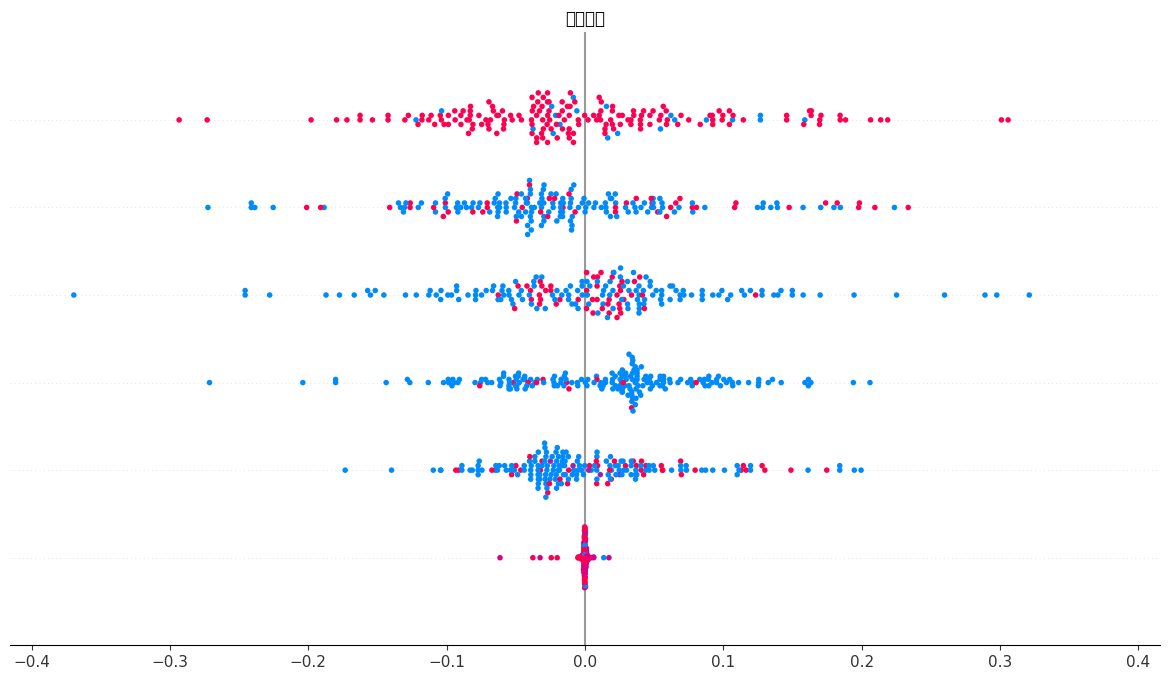

ValueError: The feature_names arg must include all features represented in shap_values.

In [ ]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 指定法院
target_court = 'ULDM'

# 選出資料
df = court_df[court_df['法院'] == target_court]
X = df[feature_cols]
y = df['刑期']

# 訓練模型
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

# Decision Plot（針對第 0 筆）
shap.decision_plot(
    explainer.expected_value[0],
    shap_values[0][0],
    pd.DataFrame([X_test.iloc[0]], columns=feature_cols),
    feature_names=feature_cols
)

# Force Plot（針對第 0 筆）
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[0], feature_names=feature_cols)


##### 看互相預測的成效

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 你定義好的簡易庭 ➝ 地方法院 對應表
em_to_dm = {
    'FYEM': 'TCDM', 'HUEM': 'ULDM', 'NHEM': 'SLDM', 'SLEM': 'SLDM',
    'SDEM': 'TCDM', 'TLEM': 'ULDM', 'PKEM': 'ULDM',
    'CPEM': 'SCDM', 'KMEM': 'KMDM', 'MKEM': 'PHDM'
}

# 特徵欄位
feature_cols = [col for col in court_df.columns if col not in ['法院', '歸屬法院', '刑期']]

# 結果列表
results_cross = []

for em, dm in em_to_dm.items():
    df_em = court_df[court_df['法院'] == em]
    df_dm = court_df[court_df['法院'] == dm]

    # 篩掉樣本數過少的組合
    if len(df_em) < 30 or len(df_dm) < 30:
        continue

    # 資料分割
    X_em, y_em = df_em[feature_cols], df_em['刑期']
    X_dm, y_dm = df_dm[feature_cols], df_dm['刑期']

    # EM 模型 ➝ 預測 DM
    model_em = RandomForestClassifier(random_state=42)
    model_em.fit(X_em, y_em)
    pred_dm_by_em = model_em.predict(X_dm)
    acc_em2dm = accuracy_score(y_dm, pred_dm_by_em)

    # DM 模型 ➝ 預測 EM
    model_dm = RandomForestClassifier(random_state=42)
    model_dm.fit(X_dm, y_dm)
    pred_em_by_dm = model_dm.predict(X_em)
    acc_dm2em = accuracy_score(y_em, pred_em_by_dm)

    # 收集結果
    results_cross.append({
        '簡易庭': em,
        '地方法院': dm,
        'EM→DM Accuracy': acc_em2dm,
        'DM→EM Accuracy': acc_dm2em,
        'EM樣本數': len(df_em),
        'DM樣本數': len(df_dm)
    })

# 轉為表格
df_cross = pd.DataFrame(results_cross)
print(df_cross.sort_values(by='DM→EM Accuracy', ascending=False))


    簡易庭  地方法院  EM→DM Accuracy  DM→EM Accuracy  EM樣本數  DM樣本數
3  SLEM  SLDM        0.219512        0.443219    907     41
2  NHEM  SLDM        0.317073        0.400000    175     41
7  CPEM  SCDM        0.409669        0.379310    493    393
6  PKEM  ULDM        0.318885        0.370968    186    646
5  TLEM  ULDM        0.266254        0.315789     76    646
1  HUEM  ULDM        0.320433        0.302326    215    646
4  SDEM  TCDM        0.231766        0.289474    152   2934
0  FYEM  TCDM        0.344240        0.225714    350   2934


#####檢查簡易庭的法官是不是輪值的

In [ ]:
years = range(2016,2023)
for year in years:
  print(year)

2016
2017
2018
2019
2020
2021
2022


In [ ]:
original_df = pd.DataFrame()

In [ ]:
for year in years:
  judge_df = pd.read_csv(f"/content/gdrive/MyDrive/NCHU/論文/酒駕資料/{year}_判決對應法官_清洗字符後.csv", encoding="utf-8", index_col=0)
  original_df = pd.concat([original_df, judge_df])

In [ ]:
df = original_df.copy()

In [ ]:
import pandas as pd

# 假設你的資料叫 df，包含 '案號' 和 '法官' 兩欄
# df = pd.read_csv("你的資料.csv")

# 萃取法院代碼（案號前4碼）
df['法院'] = df['案號'].str[:4]

# 對每個法院內部做法官案件統計
grouped = df.groupby(['法院', '法官']).size().reset_index(name='案件數')

# 顯示用：針對每個法院列出所有法官的案件數
for court in grouped['法院'].unique():
  if court in EM_court_list:
    print(f"\n📍 法院：{court}")
    subset = grouped[grouped['法院'] == court]
    for _, row in subset.iterrows():
        print(f"  {row['法官']}：{row['案件數']} 件")



📍 法院：CPEM
  傅曉瑄：434 件
  劉嶽承：4 件
  卓怡君：4 件
  吳靜怡：1 件
  周煙平：8 件
  周美玲：4 件
  周美玲 (Judge Chou Mei-Ling)：1 件
  廖素琪：39 件
  張珈禎：1 件
  張百見：3 件
  張詠晶：2 件
  李宇璿：1 件
  李建慶：3 件
  李珮瑜：1 件
  林南薰：1 件
  林哲瑜：8 件
  林宗穎：2 件
  林建鼎：38 件
  林惠君：2 件
  林涵雯：9 件
  林麗玉：1 件
  楊明箴：6 件
  楊祐庭：27 件
  楊麗文：4 件
  江宜穎：7 件
  汪銘欽：5 件
  法官：廖素琪：1 件
  湯淑嵐：3 件
  潘韋廷：7 件
  王佳惠：5 件
  王凱平：17 件
  王婉如：6 件
  王靜慧：8 件
  莊仁杰：14 件
  華澹寧：63 件
  蔡欣怡：1 件
  蔡玉琪：2 件
  賴淑敏：1 件
  邱玉汝：2 件
  郭哲宏：3 件
  鄭政宗：2 件
  陳健順：2 件
  陳麗芬：5 件
  魏瑞紅：8 件
  黃怡文：5 件
  黃美文：22 件
  黃美盈：9 件

📍 法院：FYEM
  巫淑芳：270 件
  廖弼妍：1 件
  戴博誠：3 件
  林新竑：204 件
  段奇琬：236 件
  段奇琬 (Judge Duan Qi-Wan)：6 件
  段奇琬 (Judge Duan Qi-Wen)：9 件
  法官：巫淑芳：4 件
  洪堯讚：1 件
  陳學德：4 件
  高士傑：4 件
  黃渙文：24 件

📍 法院：HUEM
  張淵森：14 件
  梁智賢：49 件
  楊皓潔：22 件
  潘韋丞：2 件
  王子榮：63 件
  王紹銘：1 件
  簡廷恩：27 件
  蔡鎮宇：14 件
  蕭于哲：16 件
  鍾世芬：14 件
  陳育良：30 件
  陳雅琪：40 件
  陳韋仁：1 件
  黃偉銘：30 件
  黃麗文 (Judge Huang Li-Wen)：1 件
  黃麗竹：8 件

📍 法院：KMEM
  吳玟儒：8 件
  林秀菊：1 件
  王鴻均：12 件
  蔡旻穎：60 件
  黃佩穎：3 件
  黃俊偉：16 件

📍 法院：MKEM
  倪霈棻：1 件
  吳宏榮：

In [ ]:
# 顯示用：針對每個法院列出所有法官的案件數
for court in grouped['法院'].unique():
  if court == "TCDM" :
    print(f"\n📍 法院：{court}")
    subset = grouped[grouped['法院'] == court]
    for _, row in subset.iterrows():
        print(f"  {row['法官']}：{row['案件數']} 件")


📍 法院：TCDM
  丁智慧：25 件
  丁智慧 (Judge Ting Chih-Hui)：1 件
  何紹甫：2 件
  何紹輔：128 件
  侯驊殷：24 件
  侯驊殷 (Judge Hou Hua-Yin)：1 件
  劉依伶：5 件
  劉依伶 (Judge Liu Yi-Ling)：1 件
  劉奕榔：37 件
  劉承翰：83 件
  劉敏芳：68 件
  劉柏駿：7 件
  劉麗瑛：19 件
  劉麗瑛 (Judge Liu Li-Ying)：3 件
  吳孟潔：11 件
  吳怡嫺：9 件
  吳欣哲：3 件
  吳珈禎：127 件
  吳逸儒：29 件
  吳金玫：19 件
  吳金玫法官。：1 件
  呂超群：5 件
  周瑞芬：1 件
  周莉菁：17 件
  周莉菁 (Judge Chou Li-chin)：1 件
  唐中興：13 件
  姚佑軍：3 件
  孫藝娜：35 件
  尚安雅：2 件
  尚安雅 (Judge Shang An-ya)：1 件
  巫淑芳：14 件
  廖弼妍：20 件
  廖慧娟：12 件
  廖穗蓁：6 件
  廖純卿：32 件
  廖素琪：13 件
  張凱鑫：16 件
  張德寬：83 件
  張意鈞：12 件
  張文俊：52 件
  張淵森：74 件
  張清洲：3 件
  張美眉：23 件
  張美眉 (Judge Chang Mei-mei)：1 件
  張道周：19 件
  張雅涵：3 件
  彭國能：8 件
  徐右家：1 件
  徐煥淵：29 件
  徐煥淵 (Judge Hsu Huan-Yun)：2 件
  戰諭威：191 件
  施吟蒨：6 件
  施懷閔：62 件
  時瑋辰：18 件
  曹錫泓：29 件
  曾佩琦：16 件
  李依達：8 件
  李婉玉：109 件
  李宜娟：8 件
  李宜璇：65 件
  李怡真：15 件
  李昇蓉：17 件
  李秋娟：3 件
  李雅俐：2 件
  林佳瑩：9 件
  林依蓉：5 件
  林德鑫：27 件
  林德鑫 (Lin De-xin)：2 件
  林忠澤：10 件
  林怡姿：77 件
  林怡姿 (Judge Lin Yi-zhi)：1 件
  林怡姿 (Lin Yi-Zhi)：3 件
  林怡姿。：1 件
 

###子實驗三

#### data

In [ ]:
years = range(2016,2023)
for year in years:
  print(year)

2016
2017
2018
2019
2020
2021
2022


In [ ]:
original_df = pd.DataFrame()

In [ ]:
for year in years:
  judge_df = pd.read_csv(f"/content/gdrive/MyDrive/NCHU/論文/酒駕資料/{year}_判決對應法官_清洗字符後.csv", encoding="utf-8", index_col=0)
  original_df = pd.concat([original_df, judge_df])

In [ ]:
original_df.head()

,案號,法官
1,"CHDM,104,交簡,2448,20160104,1",黃玉齡
2,"CHDM,104,交簡,2461,20160105,1",黃玉齡
3,"CHDM,104,交簡,2479,20160115,1",黃玉齡
4,"CHDM,104,交簡,2495,20160125,1",張琇涵
5,"CHDM,104,交簡,2659,20160111,1",陳佳妤


In [ ]:
judgemnt_df = pd.read_csv("/content/gdrive/MyDrive/NCHU/論文/酒駕資料/2014to22_判決結構化資料_清洗整理後_有序資料編碼修正後.csv", encoding="utf-8", index_col=0)

In [ ]:
judgemnt_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39058 entries, 1 to 5565
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   案號          39058 non-null  object 
 1   刑期          39058 non-null  float64
 2   呼氣酒精濃度      39058 non-null  float64
 3   是否累犯        39058 non-null  int64  
 4   是否坦承犯行      39058 non-null  int64  
 5   有無出現交通事故    39058 non-null  int64  
 6   有無乘客        39058 non-null  int64  
 7   是否為職業駕駛     39058 non-null  int64  
 8   交通工具        39058 non-null  int64  
 9   家庭經濟        39058 non-null  int64  
 10  教育程度        39058 non-null  int64  
 11  除酒駕以外的交通違規  39058 non-null  int64  
 12  易科罰金        39058 non-null  int64  
 13  併科罰金        39046 non-null  float64
dtypes: float64(3), int64(10), object(1)
memory usage: 4.5+ MB


In [ ]:
judgemnt_df.head()

,案號,刑期,呼氣酒精濃度,是否累犯,是否坦承犯行,有無出現交通事故,有無乘客,是否為職業駕駛,交通工具,家庭經濟,教育程度,除酒駕以外的交通違規,易科罰金,併科罰金
1,"CHDM,102,交簡,2712,20140102,1",3.0,0.61,0,1,1,0,1,4,0,3,1,1,0.0
2,"CHDM,102,交簡,2784,20140106,1",6.0,0.32,1,1,1,0,0,3,0,0,2,0,60.0
3,"CHDM,102,交簡,2806,20140103,1",4.0,0.53,0,1,0,0,0,4,0,0,2,1,0.0
4,"CHDM,102,交簡,2822,20140103,1",3.0,0.28,1,1,0,2,2,3,2,3,2,1,0.0
8,"CHDM,103,交簡,153,20140128,1",3.0,0.63,0,1,0,0,0,4,0,0,1,1,0.0


In [ ]:
target_year_judgemnt_df = judgemnt_df.copy()

In [ ]:
# 解析案號中的年份
target_year_judgemnt_df["年份"] = target_year_judgemnt_df["案號"].apply(lambda x: int(x.split(",")[1]))

target_year_judgemnt_df["法院"] = target_year_judgemnt_df["案號"].apply(lambda x: str(x.split(",")[0]))

# 篩選 105 年以後的案件
target_year_judgemnt_df = target_year_judgemnt_df[target_year_judgemnt_df["年份"] >= 105]

In [ ]:
target_year_judgemnt_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34104 entries, 11 to 5565
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   案號          34104 non-null  object 
 1   刑期          34104 non-null  float64
 2   呼氣酒精濃度      34104 non-null  float64
 3   是否累犯        34104 non-null  int64  
 4   是否坦承犯行      34104 non-null  int64  
 5   有無出現交通事故    34104 non-null  int64  
 6   有無乘客        34104 non-null  int64  
 7   是否為職業駕駛     34104 non-null  int64  
 8   交通工具        34104 non-null  int64  
 9   家庭經濟        34104 non-null  int64  
 10  教育程度        34104 non-null  int64  
 11  除酒駕以外的交通違規  34104 non-null  int64  
 12  易科罰金        34104 non-null  int64  
 13  併科罰金        34092 non-null  float64
 14  年份          34104 non-null  int64  
 15  法院          34104 non-null  object 
dtypes: float64(3), int64(11), object(2)
memory usage: 4.4+ MB


In [ ]:
judge_list = original_df['法官'].tolist()

In [ ]:
df_combined = pd.merge(target_year_judgemnt_df, original_df, on='案號', how='inner')

In [ ]:
df_combined.head()

,案號,刑期,呼氣酒精濃度,是否累犯,是否坦承犯行,有無出現交通事故,有無乘客,是否為職業駕駛,交通工具,家庭經濟,教育程度,除酒駕以外的交通違規,易科罰金,併科罰金,年份,法院,法官
0,"CHDM,105,交簡,156,20160130,1",3.0,0.360,0,1,1,0,0,3,3,3,2,1,0.0,105,CHDM,林于捷
1,"CHDM,105,交簡,6,20160114,1",6.0,1.220,1,1,0,0,0,4,1,2,2,1,0.0,105,CHDM,張佳燉
2,"CHDM,105,審交簡,4,20160126,1",4.0,0.530,0,1,0,0,0,4,0,2,5,1,20.0,105,CHDM,呂美玲
3,"CPEM,105,竹北交簡,2,20160127,1",2.0,0.865,0,1,1,0,0,4,0,4,0,1,0.0,105,CPEM,傅曉瑄
4,"CPEM,105,竹北交簡,30,20160127,1",4.0,0.270,1,1,0,2,0,4,0,3,2,1,0.0,105,CPEM,傅曉瑄


#### 模型

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

####全台模型

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

df = df_combined.copy()

bins = [-float('inf'), 0.24, 0.49, 0.74, 0.99, 1.49, 1.99, 3.49, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]  # 數值對應類別

# 假設 df 中有一個欄位名稱為 '呼氣酒精濃度'
df['酒精濃度類別'] = pd.cut(df['呼氣酒精濃度'], bins=bins, labels=labels, right=True).astype(int)

# 移除無關欄位
df = df.drop(columns=["案號", "法院", "年份", "易科罰金", "併科罰金", "呼氣酒精濃度"])
# 移除有 NaN 的資料列
df = df.dropna()

# 轉換類別變數
label_encoder = LabelEncoder()
df["法官"] = label_encoder.fit_transform(df["法官"])

# 目標變數（刑期）
y = df["刑期"]
X = df.drop(columns=["刑期"])

# **步驟 1: 全體法官數據切分**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **步驟 2: 訓練全體法官模型**
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# **步驟 3: 遷移學習到個別法官**
# 假設我們選擇 "鄭琬薇" 這位法官
judge_id = label_encoder.transform(["傅曉瑄"])[0]  # 找出該法官的編碼
judge_data = df[df["法官"] == judge_id]

# 個別法官數據切分 (80% 訓練, 20% 測試)
X_judge = judge_data.drop(columns=["刑期"])
y_judge = judge_data["刑期"]
X_judge_train, X_judge_test, y_judge_train, y_judge_test = train_test_split(X_judge, y_judge, test_size=0.2, random_state=42)

# **Fine-tuning: 使用個別法官數據重新訓練線性回歸模型**
model.fit(X_judge_train, y_judge_train)

# **步驟 4: 進行個別法官預測**
y_pred = model.predict(X_judge_test)

# **評估結果**
mae = mean_absolute_error(y_judge_test, y_pred)
print(f"法官: 傅曉瑄, 案件數量: {len(y_judge_test)}")
print(f"MAE: {mae}")
#mse rmse
mse = mean_squared_error(y_judge_test, y_pred)
rmse = np.sqrt(mse)

#print
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

法官: 傅曉瑄, 案件數量: 65
MAE: 0.5877190112155817
MSE: 0.7418460424147192
RMSE: 0.8613048487119523


#### 法院模型

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

df = df_combined.copy()

#留下法院 = CPEM 的資料
df = df[df["法院"] == "SLEM"]

# 移除無關欄位
df = df.drop(columns=["案號", "法院", "年份", "易科罰金", "併科罰金"])
# 移除有 NaN 的資料列
df = df.dropna()

# 轉換類別變數
label_encoder = LabelEncoder()
df["法官"] = label_encoder.fit_transform(df["法官"])

# 目標變數（刑期）
y = df["刑期"]
X = df.drop(columns=["刑期"])

# **步驟 1: 法院數據切分**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **步驟 2: 訓練法院模型**
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# **步驟 3: 遷移學習到個別法官**
# 假設我們選擇 "傅曉瑄" 這位法官
judge_id = label_encoder.transform(["張嘉芬"])[0]  # 找出該法官的編碼
judge_data = df[df["法官"] == judge_id]

# 個別法官數據切分 (80% 訓練, 20% 測試)
X_judge = judge_data.drop(columns=["刑期"])
y_judge = judge_data["刑期"]
X_judge_train, X_judge_test, y_judge_train, y_judge_test = train_test_split(X_judge, y_judge, test_size=0.2, random_state=42)

# **Fine-tuning: 使用個別法官數據重新訓練線性回歸模型**
model.fit(X_judge_train, y_judge_train)

# **步驟 4: 進行個別法官預測**
y_pred = model.predict(X_judge_test)

# **評估結果**
mae = mean_absolute_error(y_judge_test, y_pred)
print(f"法官: 張嘉芬, 案件數量: {len(y_judge_test)}")
print(f"MAE: {mae}")
#mse rmse
mse = mean_squared_error(y_judge_test, y_pred)
rmse = np.sqrt(mse)

#print
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

法官: 張嘉芬, 案件數量: 126
MAE: 0.4328497398482204
MSE: 0.4015460872704674
RMSE: 0.6336766425160922


#### 分析

In [ ]:
import statsmodels.api as sm

df = df_combined.copy()

# 移除有 NaN 的資料列
df = df.dropna()

In [ ]:
import pandas as pd

# 定義酒精濃度區間
bins = [-float('inf'), 0.24, 0.49, 0.74, 0.99, 1.49, 1.99, 3.49, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]  # 數值對應類別

# 假設 df 中有一個欄位名稱為 '呼氣酒精濃度'
df['酒精濃度類別'] = pd.cut(df['呼氣酒精濃度'], bins=bins, labels=labels, right=True).astype(int)



In [ ]:
df.head()

,案號,刑期,呼氣酒精濃度,是否累犯,是否坦承犯行,有無出現交通事故,有無乘客,是否為職業駕駛,交通工具,家庭經濟,教育程度,除酒駕以外的交通違規,易科罰金,併科罰金,年份,法院,法官,酒精濃度類別
0,"CHDM,105,交簡,156,20160130,1",3.0,0.360,0,1,1,0,0,3,3,3,2,1,0.0,105,CHDM,林于捷,2
1,"CHDM,105,交簡,6,20160114,1",6.0,1.220,1,1,0,0,0,4,1,2,2,1,0.0,105,CHDM,張佳燉,5
2,"CHDM,105,審交簡,4,20160126,1",4.0,0.530,0,1,0,0,0,4,0,2,5,1,20.0,105,CHDM,呂美玲,3
3,"CPEM,105,竹北交簡,2,20160127,1",2.0,0.865,0,1,1,0,0,4,0,4,0,1,0.0,105,CPEM,傅曉瑄,4
4,"CPEM,105,竹北交簡,30,20160127,1",4.0,0.270,1,1,0,2,0,4,0,3,2,1,0.0,105,CPEM,傅曉瑄,2


In [ ]:


# 只考慮酒精濃度與刑期的關係
X = df[['酒精濃度類別']]
X = sm.add_constant(X)  # 加入截距
y = df['刑期']

model = sm.OLS(y, X).fit()
print(model.summary())  # 查看回歸結果

                            OLS Regression Results                            
Dep. Variable:                     刑期   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2274.
Date:                Wed, 05 Mar 2025   Prob (F-statistic):               0.00
Time:                        05:33:40   Log-Likelihood:                -52581.
No. Observations:               32141   AIC:                         1.052e+05
Df Residuals:                   32139   BIC:                         1.052e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4294      0.021    117.529      0.0

In [ ]:
import statsmodels.api as sm

df = df_combined.copy()

# 移除有 NaN 的資料列
df = df.dropna()

bins = [-float('inf'), 0.24, 0.49, 0.74, 0.99, 1.49, 1.99, 3.49, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]  # 數值對應類別

# 假設 df 中有一個欄位名稱為 '呼氣酒精濃度'
df['酒精濃度類別'] = pd.cut(df['呼氣酒精濃度'], bins=bins, labels=labels, right=True).astype(int)

X = df.drop(columns=["案號","呼氣酒精濃度", "法院", "年份", "刑期", "法官","易科罰金","併科罰金"])

# 加入截距項
X = sm.add_constant(X)

# 目標變數（刑期）
y = df['刑期']

# 執行回歸
model = sm.OLS(y, X).fit()

# 顯示回歸結果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                     刑期   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     2180.
Date:                Wed, 05 Mar 2025   Prob (F-statistic):               0.00
Time:                        05:34:51   Log-Likelihood:                -45357.
No. Observations:               32141   AIC:                         9.074e+04
Df Residuals:                   32130   BIC:                         9.083e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7022      0.036     75.521      0.0

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# One-hot encoding 法官 ID
df_encoded = pd.get_dummies(df, columns=['法官ID'])

# 設定特徵與目標變數
X = df_encoded.drop(columns=['刑期'])  # 所有變數（包括 one-hot 法官 ID）
y = df_encoded['刑期']

# 建立並訓練模型
model = LinearRegression()
model.fit(X, y)

# 輸出係數
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients.sort_values(by="Coefficient", ascending=False))


In [ ]:
import pandas as pd
import statsmodels.api as sm

df = df_combined.copy()

# 移除有 NaN 的資料列
df = df.dropna()

# 讀取你的數據 (假設已經有 DataFrame `df`)
df["累犯_坦承交互"] = df["是否累犯"] * df["是否坦承犯行"]

# 定義自變數（X）和應變數（Y）
X = df[["呼氣酒精濃度", "是否累犯", "是否坦承犯行", "累犯_坦承交互",
        "有無出現交通事故", "有無乘客", "是否為職業駕駛", "交通工具",
        "家庭經濟", "教育程度", "除酒駕以外的交通違規"]]
X = sm.add_constant(X)  # 加入常數項
y = df["刑期"]

# 執行 OLS 回歸
model = sm.OLS(y, X).fit()

# 顯示結果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                     刑期   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     1590.
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:29:05   Log-Likelihood:                -46695.
No. Observations:               32141   AIC:                         9.341e+04
Df Residuals:                   32129   BIC:                         9.352e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6052      0.037     97.801      0.0

#### Lasso

In [ ]:
from sklearn.linear_model import Lasso

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd

df = df_combined.copy()

# 移除有 NaN 的資料列
df = df.dropna()

bins = [-float('inf'), 0.24, 0.49, 0.74, 0.99, 1.49, 1.99, 3.49, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]  # 數值對應類別

# 假設 df 中有一個欄位名稱為 '呼氣酒精濃度'
df['酒精濃度類別'] = pd.cut(df['呼氣酒精濃度'], bins=bins, labels=labels, right=True).astype(int)

# 假設 df 是你的 DataFrame
features = ['是否累犯', '是否坦承犯行', '酒精濃度類別', '有無出現交通事故']
target = '刑期'

X = df[features]
y = df[target]

# 創建交互項
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# 訓練線性回歸模型
model = LinearRegression()
model.fit(X_poly, y)

# 查看係數
feature_names = poly.get_feature_names_out(features)
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': model.coef_})
print(coef_df)

# 使用 Lasso 來選擇重要的交互作用項
lasso = Lasso(alpha=0.1)  # alpha 控制正則化強度
lasso.fit(X_poly, y)

# 觀察重要的交互作用項
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso.coef_})
coef_df = coef_df[coef_df['Coefficient'] != 0]  # 只保留重要的項
print(coef_df)


           Feature  Coefficient
0             是否累犯     1.680823
1           是否坦承犯行    -0.524755
2           酒精濃度類別     0.291934
3         有無出現交通事故     0.264779
4      是否累犯 是否坦承犯行     0.080642
5      是否累犯 酒精濃度類別    -0.050163
6    是否累犯 有無出現交通事故    -0.149797
7    是否坦承犯行 酒精濃度類別     0.041252
8  是否坦承犯行 有無出現交通事故     0.009622
9  酒精濃度類別 有無出現交通事故    -0.041047
       Feature  Coefficient
2       酒精濃度類別     0.069911
5  是否累犯 酒精濃度類別     0.456820


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 訓練隨機森林回歸
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# 查看變數的重要性
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


    Feature  Importance
0      是否累犯    0.829602
2    酒精濃度類別    0.147724
1    是否坦承犯行    0.015286
3  有無出現交通事故    0.007388


In [ ]:
!apt-get update
!apt-get install -y fonts-nanum  # 或者 fonts-wqy-zenhei


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,712 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,341 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-03-05 05:36:17--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.107.100, 142.250.107.113, 142.250.107.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.107.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-03-05 05:36:17--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.197.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2025-03-05 05

In [ ]:
df['是否累犯'].value_counts()

,count
是否累犯,
0,22583
1,9549
5,9


In [ ]:
#drop 是否累犯=5的 row
df = df[df['是否累犯'] != 5]

In [ ]:
df['是否累犯'].value_counts()

,count
是否累犯,
0,22583
1,9549


In [ ]:
df['是否坦承犯行'].value_counts()

,count
是否坦承犯行,
1,30120
2,1211
0,801


In [ ]:
#drop 是否坦承犯行=2的 row
df = df[df['是否坦承犯行'] != 2]

In [ ]:
df['是否坦承犯行'].value_counts()

,count
是否坦承犯行,
1,30120
0,801


In [ ]:
# 假設 df 是你的 DataFrame
features = ['是否累犯', '是否坦承犯行', '酒精濃度類別', '有無出現交通事故']
target = '刑期'

X = df[features]
y = df[target]


 99%|===================| 30485/30921 [00:31<00:00]       

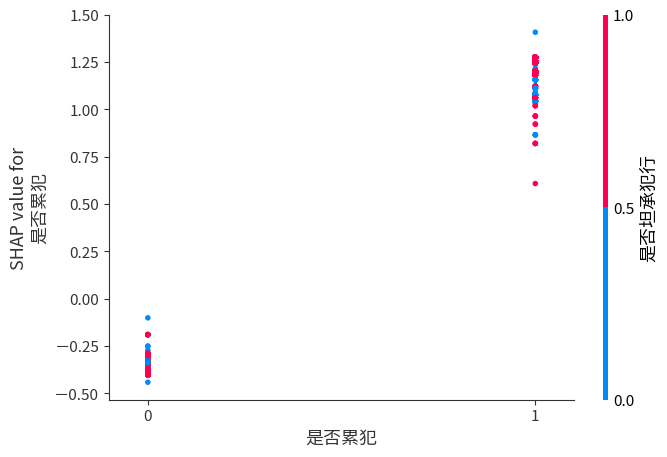

In [ ]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt


# 2. 訓練 XGBoost 模型
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 3. 計算 SHAP 值
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# 4. 以「是否累犯」為主變數，與「是否坦承犯行」為交互項進行觀察
shap.dependence_plot(
    "是否累犯",
    shap_values.values,
    X,
    interaction_index="是否坦承犯行",
    show=False
)

# 5. 只想在 X 軸顯示 0 和 1 (是否累犯)
plt.xticks([0, 1], ["0", "1"])
plt.xlim(-0.1, 1.1)

plt.show()


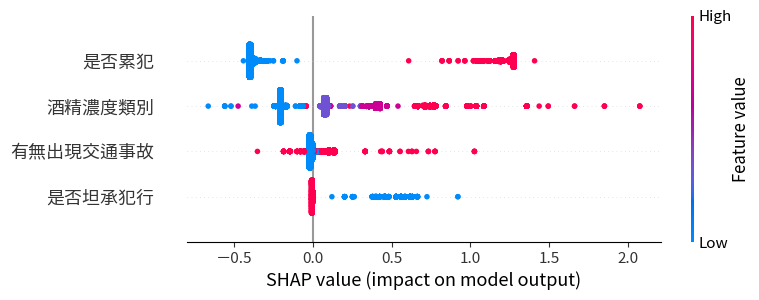

In [ ]:
import matplotlib.pyplot as plt

# 產生經典 Summary Plot (dot plot)
shap.summary_plot(shap_values.values, X, plot_type="dot")

plt.show()
